**Eric Meinhardt / emeinhardt@ucsd.edu**

In [1]:
#Prints **all** console output, not just last item in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import json

In [3]:
import codecs

def exportDict(fn, d):
    with codecs.open(fn, 'w', encoding='utf-8') as f:
        json.dump(d, f, ensure_ascii = False, indent = 4)
        
def importDict(fn):
    with open(fn, encoding='utf-8') as data_file:
        d_in = json.loads(data_file.read())
    return d_in

In [4]:
import funcy

In [5]:
from tqdm import tqdm

In [6]:
from joblib import Parallel, delayed

J = -1
BACKEND = 'multiprocessing'
# BACKEND = 'loky'
V = 10
PREFER = 'processes'
# PREFER = 'threads'

def par(gen_expr):
    return Parallel(n_jobs=J, backend=BACKEND, verbose=V, prefer=PREFER)(gen_expr)

# Overview

This notebook documents the process of creating an n-gram model from the Switchboard corpus using `kenlm`.

# 2001 release

See 
 - https://www.isip.piconepress.com/projects/switchboard/ for a very short description of Switchboard-1, Release 2.
 - http://www1.icsi.berkeley.edu/Speech/stp/description.html and https://www.isip.piconepress.com/projects/switchboard/doc/transcription_guidelines/transcription_guidelines.pdf for more on phonetic transcriptions.

In [7]:
os.getcwd()

'/mnt/cube/home/AD/emeinhar/switchboard-lm'

In [8]:
repo_dir = '/mnt/cube/home/AD/emeinhar/switchboard-lm'

In [9]:
swbd_icsi_dir = "/mnt/truffle/corpora/switchboard_icsi_phone/trans/icsi"

In [10]:
os.chdir(swbd_icsi_dir)
os.listdir()

['AAREADME.text', 'ms98_icsi_phone.text', 'ms98_icsi_word.text']

In [11]:
%cat -n AAREADME.text | head -100

     1	This release contains a version of the ICSI phonetically-transcribed
     2	data that has been mapped onto the ISIP MS98 transcriptions.
     3	There are three files in this release:
     4	
     5	 AAREADME.text        => you're looking at it
     6	 ms98_icsi_word.text  => word transcriptions
     7	 ms98_icsi_phone.text => corresponding phone transcriptions
     8	
     9	In ms98_icsi_word.text, you will find entries of the form:
    10	
    11	 sw2039A-ms98-a-0086 377.245750 384.456750 uh "after the what" uh was it the King James Version when the committee
    12	
    13	The first entry is an MS98 utterance ID. The second and third entries are
    14	the start and stop times of the MS98 utterance. The next entry is the
    15	word transcription, following the MS98 conventions.
    16	
    17	*Most importantly*, the words in quotes represent those words for which
    18	there are ICSI phonetic transcriptions.
    19	
    20	In ms98_icsi_phone.text you will find entries of the

## Significance

 - This release of the data does NOT contain all utterances in Switchboard.
 - It just contains utterances where some subsequence has been phonetically transcribed.
 - Each utterance has exactly one contiguous subsequence that has been transcribed as a sequence of phones.
 - Each utterance has duration information.
 - Each transcribed subsequence has duration information (for the length of the whole subsequence).
 - A transcription is a sequence of phones (i.e. with no boundaries of any kind).
 - There are ≈40k transcribed wordforms in this release.

## Parse `word` files

In [12]:
%cat -n ms98_icsi_word.text | head -10

     1	sw2001B-ms98-a-0012 64.180625 71.048000 yes now you know if if "every[body]- like in August when everybody's on vacation or something we can dress a little more casual" or
     2	sw2005A-ms98-a-0020 173.970875 185.294250 yeah well my uh my "uh probably one of the biggest decisions i think that was very strengthened for our family [noise] was rather than have one child make that decision"
     3	sw2005A-ms98-a-0023 208.998750 221.283375 finding a place and everybody had duties to perform you know whether it was just you know giving money or whether it was actually taking part in in a lot of the decision making you know "like finding a a proper nursing home"
     4	sw2005A-ms98-a-0024 221.283375 235.435250 and they i know they and well they had well they had they had seen it coming so "so i mean [noise] it i mean i i i i har[dly]- i" i truly wish that if something like that were to happen that my children would do something like that for me
     5	sw2005A-ms98-a-0042 334.179125 34

In [13]:
icsi_lines = []
with open("ms98_icsi_word.text", 'r') as the_file:
    for line in the_file:
#         if line[0] != '#' and line.rstrip() != '':
        icsi_lines.append(line.rstrip())
len(icsi_lines)

5397

In [14]:
from collections import Counter

In [15]:
countDoubleQuotes = lambda s: Counter(s)['"']
countDoubleQuotes('fo"ob"ar')

2

In [16]:
Counter(list(map(countDoubleQuotes,
                 icsi_lines)))

Counter({2: 5397})

Every single line has exactly two doublequote characters in it.

In [17]:
from itertools import dropwhile, takewhile, chain, zip_longest

def extractFirstQuotedSubstring(s):
#     symbols = list(s)
    symbols = s
    
    unquotedPrefix = ''.join( tuple(takewhile(lambda x: x!= '"', symbols)) )
#     print('unquotedPrefix: {0}'.format(unquotedPrefix))
    
    unQuotedPrefixRemoved = ''.join(tuple(dropwhile(lambda x: x != '"', symbols)))
#     print('unQuotedPrefixRemoved: {0}'.format(unQuotedPrefixRemoved))
    justQuotedInfix = ''.join(tuple(takewhile(lambda x: x != '"', unQuotedPrefixRemoved[1:])))
#     print('justQuotedInfix: {0}'.format(justQuotedInfix))
    
    prefixPlusInfix = unquotedPrefix + '"' + justQuotedInfix + '"'
#     print('prefixPlusInfix: {0}'.format(prefixPlusInfix))
    alignment = tuple(zip_longest(symbols,
                                  prefixPlusInfix,
                                  fillvalue='_'))
#     print('alignment: {0}'.format(alignment))
    remainingSuffix = ''.join(map(lambda pair: pair[0],
                                  dropwhile(lambda pair: pair[1] != '_',
                                            alignment)))
#     print('remainingSuffix: {0}'.format(remainingSuffix))
#     return {'quoted':justQuotedInfix, 'remainder':remainingSuffix}
    return justQuotedInfix, remainingSuffix

def extractAllQuotedSubstrings(s, acc_quotes=None):
    if acc_quotes is None:
        acc_quotes = tuple()
        
    newQuotedInfix, newRemainingSuffix = extractFirstQuotedSubstring(s)
    
    if newQuotedInfix == '':
        return acc_quotes
    if s == '':
        return acc_quotes
#     acc_quotes.append(newQuotedInfix)
    return extractAllQuotedSubstrings(newRemainingSuffix, acc_quotes + (newQuotedInfix,))

def getQuoted(speech_raw):
#     return extractAllQuotedSubstrings(speech_raw)
    return (extractFirstQuotedSubstring(speech_raw)[0], )

extractFirstQuotedSubstring('abc "123" def')
extractFirstQuotedSubstring('abc 123 def')
extractFirstQuotedSubstring('"123" def')
extractFirstQuotedSubstring('"123"')
extractFirstQuotedSubstring('"123""456"')
' '
extractAllQuotedSubstrings('abc "123" def')
extractAllQuotedSubstrings('abc 123 def')
extractAllQuotedSubstrings('"123" def')
extractAllQuotedSubstrings('"123"')
extractAllQuotedSubstrings('abc "123""456" def')
extractAllQuotedSubstrings('abc "123" def "456"')
extractAllQuotedSubstrings('abc "123" def "456" "789"')
extractAllQuotedSubstrings('abc 123 def')
extractAllQuotedSubstrings('"123" def "456')
extractAllQuotedSubstrings('"123""456"')

('123', ' def')

('', '')

('123', ' def')

('123', '')

('123', '"456"')

' '

('123',)

()

('123',)

('123',)

('123', '456')

('123', '456')

('123', '456', '789')

()

('123', '456')

('123', '456')

In [18]:
# 'sw2001B-ms98-a-0012'
def parse_icsi_utterance_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_noquotes = speech_raw
    else:
        speech_noquotes_words = speech_raw.split(' ')
        isDoubleQuote = lambda s: s == '"'
        removeDoubleQuotes = lambda w: ''.join([s for s in w if not isDoubleQuote(s)])
        speech_noquotes_words = list(map(removeDoubleQuotes, speech_noquotes_words))
#         print(speech_noquotes_words)
        speech_noquotes = ' '.join( speech_noquotes_words )
    
    if speech_raw == '':
        speech_quoted = ''
    else:
#         sp = speech_raw.split('"')
#         beginsWithQuote = [phrase for phrase in sp 
#                            if len(phrase) > 0 and phrase[0] == '"']
#         endsWithQuote = [phrase for phrase in sp 
#                          if len(phrase) > 0 and phrase[-1] == '"']
#         beginsAndEndsWithQuote = [phrase for phrase in sp 
#                                   if len(phrase) > 0 and phrase[0] == '"' and phrase[-1] == '"']
#         assert len(beginsWithQuote) == len(endsWithQuote), 'Compare:\n\t{0}\n vs.\n\t{1}\n in\n\t{2}'.format(beginsWithQuote, endsWithQuote, speech_raw_words)
#         assert len(beginsAndEndsWithQuote) == len(beginsWithQuote), 'Compare:\n\t{0}\n vs.\n\t{1}\n vs.\n\t{2} in\n\t{3}'.format(beginsWithQuote, endsWithQuote, beginsAndEndsWithQuote, speech_raw_words)
        
#         quoted = beginsAndEndsWithQuote
        quoted = getQuoted(speech_raw)
        assert len(quoted) == 0 or len(quoted) == 1, 'len(quoted) = {0}'.format(len(quoted))
        if len(quoted) == 0:
            speech_quoted = ''
        else:
            speech_quoted = quoted[0]
    
    line_rel = {'utterance_id':utterance_id,
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_quoted':speech_quoted
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [19]:
icsi_utterance_relations = list(map(parse_icsi_utterance_line, icsi_lines))
l = icsi_utterance_relations[0]
l

{'utterance_id': 'sw2001B-ms98-a-0012',
 'start': 64.180625,
 'end': 71.048,
 'duration': 6.867374999999996,
 'speech_raw': 'yes now you know if if "every[body]- like in August when everybody\'s on vacation or something we can dress a little more casual" or',
 'speech_quoted': "every[body]- like in August when everybody's on vacation or something we can dress a little more casual"}

## What and how many orthographic wordforms have been transcribed in this dataset?

About how many orthographic wordforms are transcribed (= within quoted speech)?

In [20]:
def get_transcribed_wordform_tokens_icsi(parsed_icsi_utterance_rel):
    r = parsed_icsi_utterance_rel
    tokens = r['speech_quoted'].split(' ')
    return tuple(tokens)

def approxWordformTokenCount_icsi(parsed_icsi_utterance_rel):
    r = parsed_icsi_utterance_rel
    c = len(get_transcribed_wordform_tokens_icsi(r))
    return c

In [21]:
from itertools import chain

In [22]:
orthographic_wordform_tokens_icsi = tuple(chain.from_iterable(map(get_transcribed_wordform_tokens_icsi, 
                                                                  icsi_utterance_relations)))
len(orthographic_wordform_tokens_icsi)
orthographic_unigram_counts_icsi = Counter(orthographic_wordform_tokens_icsi)
orthographic_unigram_counts_icsi.most_common()

42219

[('i', 1617),
 ('and', 1495),
 ('the', 1328),
 ('uh', 1145),
 ('you', 992),
 ('that', 990),
 ('a', 962),
 ('to', 882),
 ('of', 724),
 ('it', 685),
 ('know', 606),
 ('in', 551),
 ('yeah', 519),
 ('they', 464),
 ("it's", 435),
 ('have', 421),
 ('we', 397),
 ('is', 394),
 ('so', 393),
 ('but', 379),
 ('um', 361),
 ('like', 331),
 ('was', 328),
 ('well', 302),
 ('do', 287),
 ("that's", 278),
 ('just', 274),
 ('for', 263),
 ("don't", 261),
 ('on', 260),
 ('think', 258),
 ('oh', 249),
 ('really', 229),
 ('what', 227),
 ('or', 222),
 ('right', 218),
 ('not', 216),
 ('are', 202),
 ('with', 199),
 ('my', 187),
 ("i'm", 178),
 ('all', 172),
 ('there', 172),
 ('at', 172),
 ('one', 168),
 ('about', 165),
 ('be', 160),
 ('had', 154),
 ('if', 154),
 ('as', 147),
 ('out', 144),
 ('no', 142),
 ('then', 142),
 ('get', 142),
 ('now', 134),
 ('when', 130),
 ('some', 123),
 ('up', 120),
 ('go', 117),
 ('can', 115),
 ('because', 114),
 ('this', 112),
 ("they're", 107),
 ('lot', 107),
 ('people', 106),
 ("i

≈42k orthographic wordform tokens have been transcribed.

In [23]:
from functools import reduce

union = lambda Ss: reduce(set.union, Ss)

In [24]:
orthographic_vocabulary_icsi = union(map(lambda r: set(get_transcribed_wordform_tokens_icsi(r)),
                                    icsi_utterance_relations))
len(orthographic_vocabulary_icsi)
orthographic_vocabulary_icsi

4499

{'personnel',
 'restaurant',
 'cajuns',
 'details',
 'call',
 'Holt',
 'civic',
 'controls',
 'Iraq',
 'ankles',
 'national',
 'preventing',
 'child',
 "else's",
 'hired',
 "C's",
 'Cowboys',
 'thrill',
 'engineering',
 'literally',
 'full-fledged',
 'passing',
 'ability',
 'day',
 'ladies',
 'backs',
 'southeast',
 'non',
 'have',
 'death',
 "they'd",
 'hospitalization',
 'places',
 'Illinois',
 'strong',
 'tend',
 'chilly',
 'foundation',
 'Spring',
 'face',
 'planted',
 'a[t]-',
 'nobody',
 'community',
 'culture',
 'Columbo',
 'hilt',
 'arithmetic',
 'unwind',
 'rat',
 'tactic',
 'hastily',
 'lifestyle',
 'south',
 'strifes',
 'house',
 'news',
 'farm',
 'under',
 'vaccinations',
 'dependent',
 'friend',
 "they're",
 'Beijing',
 "you'll",
 "nobody's",
 'because',
 'standing',
 'sentencing',
 '[vocalized-noise]',
 'overseas',
 'itself',
 'footage',
 'nasty',
 'rye',
 'record',
 'thank',
 'wrong',
 'our',
 'attention',
 'ragged',
 'hoping',
 'solid',
 'site',
 'center',
 'tentatively

≈4.5k orthographic wordform types have been transcribed.

In [25]:
hasSquareBrackets = lambda w: "[" in w or "]" in w
bracketed_orthographic_words_icsi = set(filter(hasSquareBrackets,
                                          orthographic_vocabulary_icsi))
len(bracketed_orthographic_words_icsi)
bracketed_orthographic_words_icsi

304

{"-[De]troit's",
 '-[a]nother',
 '-[i]t',
 "-[it']s",
 '-[re]quires',
 '-[un]til',
 '-[w]ell',
 'Ber[muda]-',
 'Bo[hemian]-',
 'Expre[ss]-',
 'Le[land]-',
 'Phil[ip]-',
 'Ply[mouth]-',
 'Sat[urday]-',
 'Sea[gull]-',
 'Te[xas]-',
 'Tex[as]-',
 '[annuitity/annuity]',
 '[ar[f]-/off]',
 '[assumingly/assumably]',
 '[civinal/civil]',
 '[laughter-Avon]',
 '[laughter-God]',
 '[laughter-a]',
 '[laughter-about]',
 '[laughter-all]',
 '[laughter-am]',
 '[laughter-and]',
 '[laughter-around]',
 '[laughter-bait]',
 '[laughter-basis]',
 '[laughter-books]',
 '[laughter-boy]',
 '[laughter-but]',
 '[laughter-closely]',
 '[laughter-day]',
 '[laughter-enough]',
 '[laughter-ever]',
 '[laughter-every]',
 '[laughter-everybody]',
 '[laughter-experience]',
 '[laughter-for]',
 '[laughter-get]',
 '[laughter-goes]',
 '[laughter-gone]',
 '[laughter-good]',
 '[laughter-got]',
 '[laughter-guns]',
 '[laughter-heard]',
 "[laughter-i'm]",
 "[laughter-i've]",
 '[laughter-i]',
 '[laughter-in]',
 '[laughter-incredibly]',
 

≈304 of those types involve brackets and plausibly require further pre or post-processing.

## How many conversations are data taken from?

In [26]:
'sw2001B-ms98-a-0012'

'sw2001B-ms98-a-0012'

In [27]:
def extract_conversation_id(utterance_id):
    return utterance_id[2:6]
extract_conversation_id('sw2001B-ms98-a-0012')

'2001'

In [28]:
icsi_conversation_ids_list = list(map(lambda rel: extract_conversation_id(rel['utterance_id']),
                                      icsi_utterance_relations))
len(set(icsi_conversation_ids_list))
Counter(icsi_conversation_ids_list).most_common()

1629

[('2830', 100),
 ('2887', 80),
 ('2547', 15),
 ('2780', 15),
 ('2661', 14),
 ('2145', 13),
 ('2005', 12),
 ('2482', 12),
 ('2776', 12),
 ('2969', 12),
 ('2019', 11),
 ('2040', 11),
 ('2051', 11),
 ('2334', 11),
 ('2362', 11),
 ('2938', 11),
 ('2953', 11),
 ('2020', 10),
 ('2028', 10),
 ('2065', 10),
 ('2085', 10),
 ('2157', 10),
 ('2426', 10),
 ('2499', 10),
 ('2534', 10),
 ('2755', 10),
 ('2766', 10),
 ('2851', 10),
 ('2909', 10),
 ('3115', 10),
 ('2064', 9),
 ('2086', 9),
 ('2154', 9),
 ('2260', 9),
 ('2353', 9),
 ('2389', 9),
 ('2427', 9),
 ('2451', 9),
 ('2460', 9),
 ('2467', 9),
 ('2472', 9),
 ('2506', 9),
 ('2584', 9),
 ('2586', 9),
 ('2603', 9),
 ('2610', 9),
 ('2623', 9),
 ('2711', 9),
 ('2723', 9),
 ('2772', 9),
 ('2793', 9),
 ('2847', 9),
 ('2877', 9),
 ('2941', 9),
 ('2959', 9),
 ('3028', 9),
 ('3111', 9),
 ('3658', 9),
 ('4026', 9),
 ('4171', 9),
 ('4372', 9),
 ('4483', 9),
 ('4617', 9),
 ('4707', 9),
 ('4940', 9),
 ('2039', 8),
 ('2181', 8),
 ('2197', 8),
 ('2237', 8),
 ('

Utterances are from 1629 distinct conversations.

## Parsing the `phones` files

In [29]:
%pwd

'/mnt/truffle/corpora/switchboard_icsi_phone/trans/icsi'

In [30]:
%ls

AAREADME.text*  ms98_icsi_phone.text*  ms98_icsi_word.text*


In [31]:
%cat -n ms98_icsi_phone.text | head -10

     1	sw2001B-ms98-a-0012 66.168250 70.294998 eh v r iy l ay k ih n ao g ix s w eh n eh r_co_! r_! iy b aa d iy z_vl aa n v ey k ey sh ih_vl n er s ah m th ih ng k_epi w iy k ix n d r eh s el l el m ao r k ae zh w ax l h#
     2	sw2005A-ms98-a-0020 176.845000 185.135000 sil h# sil pv p r aa b l uw w ah_n ah v dh ix b ih g ix ? d ih s ih zh_vl ih n z_vl h# q ay th ih ng k dh ih w_cr_co w_cr uh z_vl sil v eh r iy s t r eh ng k th ax n d f aa r f ae m l ax w_co w ah z_vl h# r ae dh ix dh eh n hh ae v w ah n ch ay l_cr m ey k dh ae_cr d ix s ih zh_vl ih n h#
     3	sw2005A-ms98-a-0023 218.695000 221.165000 h# l ay_cr k f ay n ih_n ng ax_cr ax p r aa p er n er s ih_n ng hh ow_cr m h#
     4	sw2005A-ms98-a-0024 227.255000 230.725000 h# s ow w_on iy q aa m iy nx ih ih_cr t_vd h# aa m iy nx ay ay h# ay q aa hh eh_fr hh aa r q ay h# 
     5	sw2005A-ms98-a-0042 334.225000 335.515000 h# ih t w ah z ih n t h#
     6	sw2005A-ms98-a-0052 390.955000 394.545000 h# w iy h# w iy d ow n t h# w iy h# w i

There are
 - no word boundaries

...and therefore aren't really any word transcriptions directly available from this data (or word durations or phone durations).

# 2003 release

See https://www.isip.piconepress.com/projects/switchboard/.

In [32]:
swbd2003_dir = "/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions"

In [33]:
%ls

AAREADME.text*  ms98_icsi_phone.text*  ms98_icsi_word.text*


In [34]:
%cat -n AAREADME.text | head -100

     1	This release contains a version of the ICSI phonetically-transcribed
     2	data that has been mapped onto the ISIP MS98 transcriptions.
     3	There are three files in this release:
     4	
     5	 AAREADME.text        => you're looking at it
     6	 ms98_icsi_word.text  => word transcriptions
     7	 ms98_icsi_phone.text => corresponding phone transcriptions
     8	
     9	In ms98_icsi_word.text, you will find entries of the form:
    10	
    11	 sw2039A-ms98-a-0086 377.245750 384.456750 uh "after the what" uh was it the King James Version when the committee
    12	
    13	The first entry is an MS98 utterance ID. The second and third entries are
    14	the start and stop times of the MS98 utterance. The next entry is the
    15	word transcription, following the MS98 conventions.
    16	
    17	*Most importantly*, the words in quotes represent those words for which
    18	there are ICSI phonetic transcriptions.
    19	
    20	In ms98_icsi_phone.text you will find entries of the

What information is in this release?

In [35]:
from itertools import filterfalse

In [36]:
os.chdir(swbd2003_dir)
os.listdir()
swbd2003_folders = list(filterfalse(lambda s: s[-5:] == '.text', os.listdir()))
swbd2003_folders

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 'AAREADME.text',
 'sw-ms98-dict.text']

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49']

In [37]:
%ls 20

2001/  2010/  2018/  2025/  2038/  2050/  2057/  2067/  2080/  2089/  2095/
2005/  2012/  2019/  2027/  2039/  2051/  2060/  2071/  2082/  2090/  2096/
2006/  2013/  2020/  2028/  2040/  2053/  2061/  2072/  2083/  2091/
2007/  2014/  2022/  2032/  2041/  2054/  2062/  2073/  2085/  2092/
2008/  2015/  2023/  2035/  2044/  2055/  2064/  2078/  2086/  2093/
2009/  2017/  2024/  2036/  2045/  2056/  2065/  2079/  2087/  2094/


In [38]:
%ls 20/2001

sw2001A-ms98-a-trans.text*  sw2001B-ms98-a-trans.text*
sw2001A-ms98-a-word.text*   sw2001B-ms98-a-word.text*


In [39]:
# swbd2003_files = []
conversation_ids = []
for folder in swbd2003_folders:
    os.chdir(folder)
    conversation_ids.extend(os.listdir())
    os.chdir('..')
len(conversation_ids)
conversation_ids[:30]

2438

['2001',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2012',
 '2013',
 '2014',
 '2015',
 '2017',
 '2018',
 '2019',
 '2020',
 '2022',
 '2023',
 '2024',
 '2025',
 '2027',
 '2028',
 '2032',
 '2035',
 '2036',
 '2038',
 '2039',
 '2040',
 '2041',
 '2044',
 '2045']

In [40]:
%cat -n ./20/2001/sw2001A-ms98-a-trans.text | head -50

     1	sw2001A-ms98-a-0001 0.000000 0.977625 [silence]
     2	sw2001A-ms98-a-0002 0.977625 11.561375 hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear
     3	sw2001A-ms98-a-0003 11.561375 19.804875 [silence]
     4	sw2001A-ms98-a-0004 19.804875 21.312375 um-hum
     5	sw2001A-ms98-a-0005 21.312375 27.362000 [silence]
     6	sw2001A-ms98-a-0006 27.362000 28.932750 and is
     7	sw2001A-ms98-a-0007 28.932750 33.898250 [silence]
     8	sw2001A-ms98-a-0008 33.898250 40.123250 right right is there is there um an[y]- is there a like a code of dress where you work do they ask
     9	sw2001A-ms98-a-0009 40.123250 41.552625 right
    10	sw2001A-ms98-a-0010 41.552625 50.129500 [silence]
    11	sw2001A-ms98-a-0011 50.129500 51.567500 [noise] right
    12	sw2001A-ms98-a-0012 51.567500 56.957000 [silence]
    13	sw2001A-ms98-a-0013 56.957000 65.593625 right right and does it does it change i guess um you can can

In [41]:
%cat -n ./20/2001/sw2001A-ms98-a-word.text | head -100

     1	sw2001A-ms98-a-0001 0.000000 0.977625 [silence]
     2	sw2001A-ms98-a-0002 0.977625 1.215250 [silence]
     3	sw2001A-ms98-a-0002 1.215250 1.724625 hi
     4	sw2001A-ms98-a-0002 1.724625 2.273625 [silence]
     5	sw2001A-ms98-a-0002 2.273625 2.927625 um
     6	sw2001A-ms98-a-0002 2.927625 3.221500 [silence]
     7	sw2001A-ms98-a-0002 3.221500 3.661750 yeah
     8	sw2001A-ms98-a-0002 3.661750 3.957625 i'd
     9	sw2001A-ms98-a-0002 3.957625 4.107625 like
    10	sw2001A-ms98-a-0002 4.107625 4.267625 to
    11	sw2001A-ms98-a-0002 4.267625 4.527625 talk
    12	sw2001A-ms98-a-0002 4.527625 4.941625 about
    13	sw2001A-ms98-a-0002 4.941625 5.126125 [silence]
    14	sw2001A-ms98-a-0002 5.126125 5.307625 how
    15	sw2001A-ms98-a-0002 5.307625 5.437625 you
    16	sw2001A-ms98-a-0002 5.437625 5.735375 dress
    17	sw2001A-ms98-a-0002 5.735375 5.901125 [silence]
    18	sw2001A-ms98-a-0002 5.901125 6.077625 for
    19	sw2001A-ms98-a-0002 6.077625 6.477625 work
    20	sw2001A-ms98-a-0002 6

For each of ≈2400 conversations, there is 
 - a sequence of utterances for speaker A.
 - a sequence of utterances for speaker B.
 - a sequence of orthographic wordforms (and non-speech events) for speaker A.
 - a sequence of orthographic wordforms (and non-speech events) for speaker B.
 
For each utterance, there is a start and end time.

For each orthographic wordform or non-speech event, there is a duration.

## Retrieving files from conversation ids

In [42]:
swbd2003_dir

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions'

In [43]:
%ls

20/  23/  26/  29/  32/  35/  38/  41/  44/  47/  AAREADME.text*
21/  24/  27/  30/  33/  36/  39/  42/  45/  48/  sw-ms98-dict.text*
22/  25/  28/  31/  34/  37/  40/  43/  46/  49/


In [44]:
%ls 20/2001

sw2001A-ms98-a-trans.text*  sw2001B-ms98-a-trans.text*
sw2001A-ms98-a-word.text*   sw2001B-ms98-a-word.text*


In [45]:
conversation_ids = set(conversation_ids)

In [46]:
def getDir(conversation_id):
    assert conversation_id in conversation_ids, '{0} is not a conversation id'.format(conversation_id)
    firstTwoDigits = conversation_id[:2]
    return os.path.join(swbd2003_dir, firstTwoDigits + '/' + conversation_id)

def getFilenames(conversation_id):
    assert conversation_id in conversation_ids, '{0} is not a conversation id'.format(conversation_id)
    return os.listdir(getDir(conversation_id))

getDir('2045')
getFilenames('2045')

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045'

['sw2045A-ms98-a-trans.text',
 'sw2045A-ms98-a-word.text',
 'sw2045B-ms98-a-trans.text',
 'sw2045B-ms98-a-word.text']

In [47]:
def getUtteranceFP(conversation_id, speaker):
    fp_prefix = getDir(conversation_id)
    
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    fn_prefix = 'sw'
    fn_suffix = '-ms98-a-trans.text'
    fn = fn_prefix + conversation_id + speaker + fn_suffix
    assert fn in set(getFilenames(conversation_id))
    
    return os.path.join(fp_prefix, fn)

def getWordFP(conversation_id, speaker):
    fp_prefix = getDir(conversation_id)
    
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    fn_prefix = 'sw'
    fn_suffix = '-ms98-a-word.text'
    fn = fn_prefix + conversation_id + speaker + fn_suffix
    assert fn in set(getFilenames(conversation_id))
    
    return os.path.join(fp_prefix, fn)

getUtteranceFP('2045','A')
getWordFP('2045','A')

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-trans.text'

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-word.text'

In [48]:
%cat -n /mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-trans.text | head -10

     1	sw2045A-ms98-a-0001 0.000000 1.411625 all right
     2	sw2045A-ms98-a-0002 1.411625 3.668625 i play volleyball and
     3	sw2045A-ms98-a-0003 3.668625 6.593875 softball and ceramics
     4	sw2045A-ms98-a-0004 6.593875 19.817125 [silence]
     5	sw2045A-ms98-a-0005 19.817125 21.945500 i didn't think of working out as a hobby
     6	sw2045A-ms98-a-0006 21.945500 22.259750 [laughter]
     7	sw2045A-ms98-a-0007 22.259750 25.479625 or playing with the computer i do both at home
     8	sw2045A-ms98-a-0008 25.479625 35.911625 [silence]
     9	sw2045A-ms98-a-0009 35.911625 43.178125 uh we've gotten a little Atari computer uh husband describes it as a a computer with training wheels
    10	sw2045A-ms98-a-0010 43.178125 44.533500 uh


## Parsing the utterance files

In [49]:
def parse_swbd_utterance_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_OnlyWords = ''
        has_word_internal_brackets = False
    else:
        speech_wordforms = speech_raw.split(' ')
        speech_wordforms = [w for w in speech_wordforms if len(w) > 0 and w[0] != '[' and w[-1] != ']']
        speech_OnlyWords = ' '.join(speech_wordforms)
        hasBrackets = lambda w: "[" in w or "]" in w
        has_word_internal_brackets = True if any(list(map(hasBrackets, speech_wordforms))) else False
#         if any(list(map(hasBrackets, speech_wordforms))):
#             raise Exception("Word-internal brackets found in\n\t{0}".format(speech_OnlyWords))
    
    has_words = False if len(speech_raw) == 0 or (speech_raw[0] == '[' and speech_raw[-1] == ']') else True
    
    line_rel = {'utterance_id':utterance_id,
                'conversation_id':utterance_id[2:6],
                'speaker':utterance_id[6:7],
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_words':speech_OnlyWords,
                'n_words':len(speech_OnlyWords.split(' ')),
                'has_words':has_words,
                'has_word_internal_brackets':has_word_internal_brackets
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [50]:
def read_swbd_file(swbd_fp):
    lines = []
    with open(swbd_fp, 'r') as the_file:
        for line in the_file:
            lines.append(line.rstrip())
    return lines

def get_utterance_relations(conversation_id, speaker):
    utterance_fp = getUtteranceFP(conversation_id, speaker)
    file_lines = read_swbd_file(utterance_fp)
    parsed_rel = tuple([parse_swbd_utterance_line(l) for l in file_lines])
    return parsed_rel

In [51]:
utts_2045A = get_utterance_relations('2045', 'A')
utts_2045A[:10]

({'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.0,
  'end': 1.411625,
  'duration': 1.411625,
  'speech_raw': 'all right',
  'speech_words': 'all right',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0002',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 1.411625,
  'end': 3.668625,
  'duration': 2.257,
  'speech_raw': 'i play volleyball and',
  'speech_words': 'i play volleyball and',
  'n_words': 4,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0003',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 3.668625,
  'end': 6.593875,
  'duration': 2.9252499999999997,
  'speech_raw': 'softball and ceramics',
  'speech_words': 'softball and ceramics',
  'n_words': 3,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0004',
  'conversation_id': '2045',
  'speaker': 

## Parsing the word files

In [52]:
%cat -n ./20/2001/sw2001A-ms98-a-word.text | head -10

     1	sw2001A-ms98-a-0001 0.000000 0.977625 [silence]
     2	sw2001A-ms98-a-0002 0.977625 1.215250 [silence]
     3	sw2001A-ms98-a-0002 1.215250 1.724625 hi
     4	sw2001A-ms98-a-0002 1.724625 2.273625 [silence]
     5	sw2001A-ms98-a-0002 2.273625 2.927625 um
     6	sw2001A-ms98-a-0002 2.927625 3.221500 [silence]
     7	sw2001A-ms98-a-0002 3.221500 3.661750 yeah
     8	sw2001A-ms98-a-0002 3.661750 3.957625 i'd
     9	sw2001A-ms98-a-0002 3.957625 4.107625 like
    10	sw2001A-ms98-a-0002 4.107625 4.267625 to


In [53]:
def parse_swbd_word_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_OnlyWords = ''
        has_word_internal_brackets = False
    else:
        speech_wordforms = speech_raw.split(' ')
        speech_wordforms = [w for w in speech_wordforms if len(w) > 0 and w[0] != '[' and w[-1] != ']']
        speech_OnlyWords = ' '.join(speech_wordforms)
        hasBrackets = lambda w: "[" in w or "]" in w
        has_word_internal_brackets = True if any(list(map(hasBrackets, speech_wordforms))) else False
#         if any(list(map(hasBrackets, speech_wordforms))):
#             raise Exception("Word-internal brackets found in\n\t{0}".format(speech_OnlyWords))
    
    has_words = False if len(speech_raw) == 0 or (speech_raw[0] == '[' and speech_raw[-1] == ']') else True
    
    line_rel = {'utterance_id':utterance_id,
                'conversation_id':utterance_id[2:6],
                'speaker':utterance_id[6:7],
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_words':speech_OnlyWords,
                'has_words':has_words,
                'has_word_internal_brackets':has_word_internal_brackets
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [54]:
def get_word_relations(conversation_id, speaker):
    word_fp = getWordFP(conversation_id, speaker)
    file_lines = read_swbd_file(word_fp)
    parsed_rel = tuple([parse_swbd_word_line(l) for l in file_lines])
    return parsed_rel

In [55]:
words_2045A = get_word_relations('2045', 'A')
words_2045A[:10]

({'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.0,
  'end': 0.47125,
  'duration': 0.47125,
  'speech_raw': '[silence]',
  'speech_words': '',
  'has_words': False,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.47125,
  'end': 0.640625,
  'duration': 0.169375,
  'speech_raw': 'all',
  'speech_words': 'all',
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.640625,
  'end': 0.909125,
  'duration': 0.26849999999999996,
  'speech_raw': 'right',
  'speech_words': 'right',
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.909125,
  'end': 1.411625,
  'duration': 0.5025,
  'speech_raw': '[silence]',
  'speech_words': '',
  'ha

## Conversation counts, utterance counts, orthographic wordform type, and wordform token counts

In [56]:
len(conversation_ids)

2438

In [57]:
#46.1 s on wittgenstein
utterances = []
for conversation_id in conversation_ids:
    utterances.extend(get_utterance_relations(conversation_id, 'A'))
    utterances.extend(get_utterance_relations(conversation_id, 'B'))
len(utterances)

391593

In [58]:
utterances_with_some_words = [u for u in utterances if u['has_words']]
len(utterances_with_some_words)

247820

In [59]:
def getWordformTokens(utterance_rel):
    return utterance_rel['speech_words'].split(' ')

In [60]:
wordformTokens = []
for u in utterances_with_some_words:
    wordformTokens.extend(getWordformTokens(u))
len(wordformTokens)

3061079

In [61]:
orthographic_wordform_counter_swbd = Counter(wordformTokens)
orthographic_wordform_counter_swbd.most_common()

[('i', 117426),
 ('and', 108317),
 ('the', 96758),
 ('you', 80725),
 ('a', 72224),
 ('to', 70207),
 ('uh', 69677),
 ('that', 65877),
 ('it', 55114),
 ('of', 54812),
 ('know', 47842),
 ('yeah', 47173),
 ('in', 39811),
 ('they', 32892),
 ('have', 29368),
 ('but', 28803),
 ("it's", 27275),
 ('so', 27016),
 ('we', 25258),
 ('is', 24372),
 ('was', 23768),
 ('like', 23272),
 ('well', 22434),
 ('just', 22199),
 ('um', 21137),
 ("that's", 20723),
 ('do', 20556),
 ('for', 19602),
 ('think', 19088),
 ("don't", 18800),
 ('oh', 18762),
 ('or', 16874),
 ('on', 16672),
 ('right', 16664),
 ('uh-huh', 16285),
 ('um-hum', 15997),
 ('what', 14847),
 ('my', 14814),
 ('really', 14756),
 ('not', 14332),
 ('be', 14035),
 ('with', 13846),
 ('are', 13243),
 ('if', 13181),
 ('there', 12801),
 ('one', 12567),
 ("i'm", 12296),
 ('all', 11856),
 ('get', 11681),
 ('about', 11642),
 ('had', 10888),
 ('out', 10866),
 ('at', 10656),
 ('as', 10002),
 ('up', 9788),
 ('this', 9603),
 ('when', 9558),
 ('he', 9527),
 ('lo

In [62]:
orthographic_wordform_types = set(wordformTokens)
len(orthographic_wordform_types)

36159

In [63]:
orthographic_wordforms_with_brackets = {w for w in orthographic_wordform_types if hasSquareBrackets(w)}
len(orthographic_wordforms_with_brackets)
orthographic_wordforms_with_brackets

6244

{'ol[dest]-',
 'k[eep]-',
 'w[as]-',
 's[tupid]-',
 't[itle]-',
 'r[ed]-',
 'termi[nology]-',
 'any[body]-',
 'Ha[ll]-',
 'e[vident]-',
 'd[own]-',
 't[alked]-',
 'paren[ts]-',
 'Bur[eau]-',
 'e[xagerrating]-',
 'nor[thern]-',
 'fad[ing]-',
 'St[ate]-',
 'Tr[ade]-',
 'st[ation]-',
 'South[field]-',
 'p[rices]-',
 'e[xperienced]-',
 'h[ey]-',
 'n[one]-',
 'Reynold[s]-',
 'alo[ne]-',
 'mo[ment]-',
 'compu[ters]-',
 'cou[ntry]-',
 'p[an]-',
 'f[inds]-',
 'tra[veled]-',
 'in[fluenced]-',
 '-[su]pposed',
 'jewel[ry]-',
 'ex[ercise]-',
 'fa[r]-',
 'r[easons]-',
 'd[oes]-',
 'mo[lestations]-',
 'Cama[ro]-',
 's[etback]-',
 'influ[enced]-',
 'advan[tages]-',
 'se[curity]-',
 'di[d]-',
 'impract[ical]-',
 'm[ultimillions]-',
 'ma[king]-',
 'f[ind]-',
 'excu[se]-',
 'ex[actly]-',
 'Pres[ley]-',
 'co[mmercials]-',
 'apprec[iate]-',
 'wor[king]-',
 '-[con]tro[l]-',
 'diff[erent]-',
 'le[gislation]-',
 'p[ercentage]-',
 'in[side]-',
 'perc[entage]-',
 'fee[l]-',
 '-[c]ourse',
 'dinn[er]-',
 's[avin

### Summary

There are
 - ≈2400 conversations.
 - ≈250k (pre-segmented) utterances.
 - ≈3m wordform tokens.
 - somewhere between 31k and 37k wordform types. (≈6k "orthographic wordforms" are interrupted or repaired wordforms.)
 
Other notes:
 - every utterance and wordform token has a duration associated with it.
 - whatever's done with this corpus should take into account broken/repaired wordforms.

## Investigation of existing utterance segmentation

 - For each utterance, let "the next consecutive utterance" denote the next utterance by **either speaker in the conversation**.

What is the distribution over 
 - times between utterance onsets
 - utterance lengths (in s)
 - utterance lengths (in orthographic wordforms)

in this release of the corpus?

In [64]:
utterances[0]

{'utterance_id': 'sw3643A-ms98-a-0001',
 'conversation_id': '3643',
 'speaker': 'A',
 'start': 0.0,
 'end': 2.381875,
 'duration': 2.381875,
 'speech_raw': '[noise] okay uh do you have children',
 'speech_words': 'okay uh do you have children',
 'n_words': 6,
 'has_words': True,
 'has_word_internal_brackets': False}

In [65]:
utterance_durations = [u['duration'] for u in utterances]
len(utterance_durations)

391593

In [66]:
utterance_lengths = [len(u['speech_words'].split(' ')) for u in utterances]
len(utterance_lengths)

391593

In [67]:
def conversationIDtoUtterances(conversation_id, removeSilentTurns=False):
    us_A = get_utterance_relations(conversation_id, 'A')
    us_B = get_utterance_relations(conversation_id, 'B')
    if removeSilentTurns:
        us_A = [u for u in us_A if u['has_words']]
        us_B = [u for u in us_B if u['has_words']]
    return sorted(us_A + us_B, key=lambda u:u['start'])

In [68]:
conversationIDtoUtterances('2001')

[{'utterance_id': 'sw2001A-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.0,
  'end': 0.977625,
  'duration': 0.977625,
  'speech_raw': '[silence]',
  'speech_words': '',
  'n_words': 1,
  'has_words': False,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001B-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 0.0,
  'end': 2.655625,
  'duration': 2.655625,
  'speech_raw': 'okay hi',
  'speech_words': 'okay hi',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001A-ms98-a-0002',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.977625,
  'end': 11.561375,
  'duration': 10.58375,
  'speech_raw': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'speech_words': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you

In [69]:
conversationIDtoUtterances('2001', True)

[{'utterance_id': 'sw2001B-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 0.0,
  'end': 2.655625,
  'duration': 2.655625,
  'speech_raw': 'okay hi',
  'speech_words': 'okay hi',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001A-ms98-a-0002',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.977625,
  'end': 11.561375,
  'duration': 10.58375,
  'speech_raw': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'speech_words': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'n_words': 30,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001B-ms98-a-0003',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 10.166375,
  'end': 22.8135,
  'duration': 12.647125,
  'speech_raw': 'wel

In [70]:
utterance_ids = sorted([u['utterance_id'] for u in utterances])
utterance_ids[:10]

['sw2001A-ms98-a-0001',
 'sw2001A-ms98-a-0002',
 'sw2001A-ms98-a-0003',
 'sw2001A-ms98-a-0004',
 'sw2001A-ms98-a-0005',
 'sw2001A-ms98-a-0006',
 'sw2001A-ms98-a-0007',
 'sw2001A-ms98-a-0008',
 'sw2001A-ms98-a-0009',
 'sw2001A-ms98-a-0010']

In [71]:
#6.71s on Wittgenstein
times_between_onsets = []
for conversation_id in conversation_ids:
    my_utts = conversationIDtoUtterances(conversation_id, True)
    starts = my_utts[:-1]
    ends = my_utts[1:]
    adjacent_pairs = zip(starts, ends)
    time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
    times_to_next_utt = list(map(time_between_onsets,
                                 adjacent_pairs))
    times_between_onsets.extend(times_to_next_utt)

In [72]:
import pandas as pd
from plotnine import *

In [73]:
durations_df = pd.DataFrame(list(map(lambda d: {"Duration":d},
                                     utterance_durations)))
lengths_df = pd.DataFrame(list(map(lambda d: {"Length":d},
                                   utterance_lengths)))
onset_deltas_df = pd.DataFrame(list(map(lambda d: {"Onset_Delta":d},
                                        times_between_onsets)))

In [74]:
durations_df.sort_values(by="Duration", ascending=False)

,Duration
350822,136.196375
8244,125.535750
44615,125.251250
290457,119.618875
379732,115.686250
123261,108.225250
46996,103.888000
23216,102.836250
123250,101.484250
284048,99.691875


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 1007'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


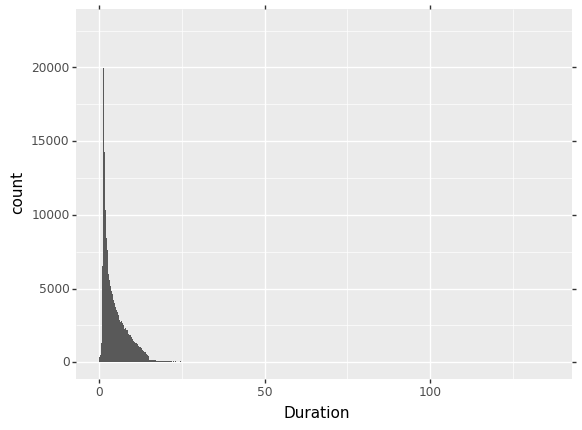

<ggplot: (8776001825341)>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 148'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 4049 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/pyt

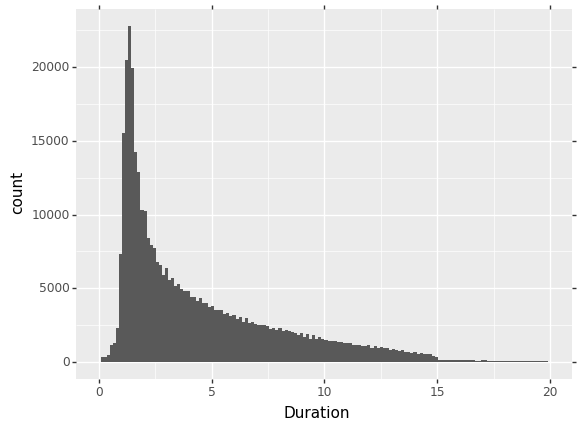

<ggplot: (8776001835569)>

In [75]:
ggplot(durations_df, aes(x="Duration")) + geom_histogram()
ggplot(durations_df, aes(x="Duration")) + geom_histogram() + xlim(0.0, 20.0)

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 267'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


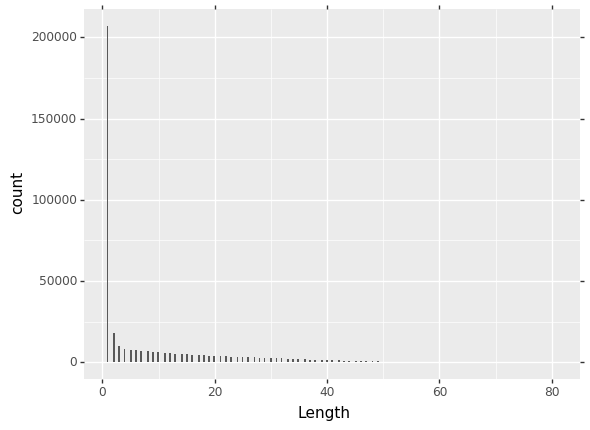

<ggplot: (8776004004985)>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 163'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 2079 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/pyt

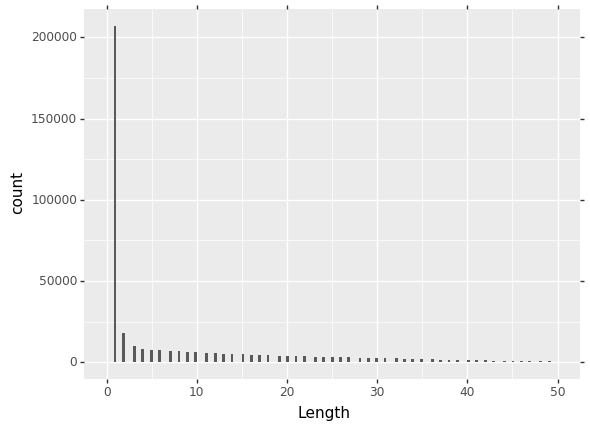

<ggplot: (8776003373425)>

In [76]:
ggplot(lengths_df, aes(x="Length")) + geom_histogram()
ggplot(lengths_df, aes(x="Length")) + geom_histogram() + xlim(0.0, 50.0)

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 549'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


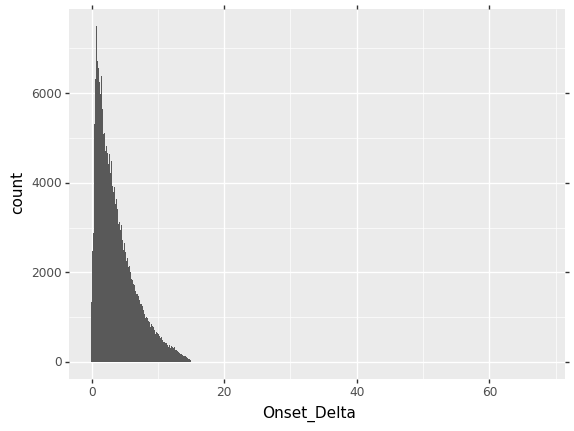

<ggplot: (8776007903641)>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 161'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/pytho

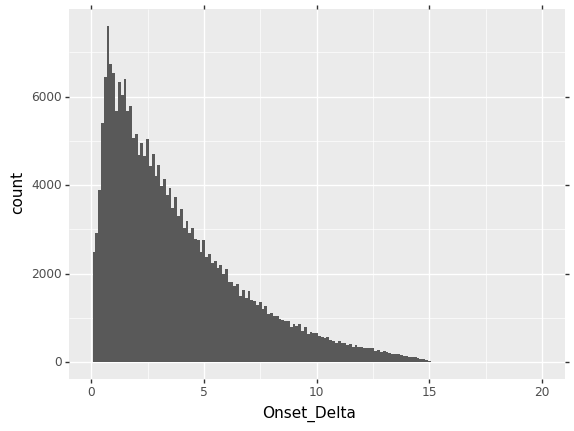

<ggplot: (8776008126417)>

In [77]:
ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram()
ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 20.0)

# NXT Switchboard

## Background

The NXT Switchboard corpus has an enormous amount of annotation on it. See
 - http://groups.inf.ed.ac.uk/switchboard/structure.html
 - http://groups.inf.ed.ac.uk/switchboard/datasum.html
 - http://groups.inf.ed.ac.uk/switchboard/coverage.html
 - .../switchboard_NXT_annotations/nxt_switchboard_ann/xml/swbd-metadata.xml

for more on the structure of the annotations.

We want (minimally, at this point) to relate
 - each `conversation id` in the corpus
 - with the set of `turn`s by each `speaker` in the associated conversation

We also want to associate 
 - each `turn` 
 - with `start`/`stop` times and a sequence of `terminal`s (by way of `NT`s)
 
and
 - each (`word`) `terminal`
 - with a `POS` tag (and maybe `start`/`stop` times) and `phonword`s.

and
 - each `phonword`
 - with `start`/`stop` times and a sequence of `phones`
 
and
 - each `phone`
 - with `start`/`stop` times

In [78]:
nxt_dir = "/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann"

In [79]:
os.chdir(nxt_dir)
os.listdir()

['docs',
 'lib',
 'xml',
 'index.html',
 'nxt_1.4.3.tgz',
 'switchboard-guis.bat',
 'switchboard-guis.sh']

In [80]:
os.chdir('xml')
os.listdir()

['accent',
 'active',
 'breaks',
 'coreference',
 'corpus-resources',
 'dialAct',
 'disfluency',
 'kontrast',
 'markable',
 'movement',
 'phones',
 'phonwords',
 'phrase',
 'prosnotes',
 'syllables',
 'syntax',
 'terminals',
 'turns',
 'swbd-metadata.xml',
 'swconfig.xml']

In [81]:
def extract_conversation_IDs_from_filename(fn):
    return fn[2:6]

def conversations_covered_in_fp(fp):
    return set(map(extract_conversation_IDs_from_filename,
                   os.listdir(fp)))

def getFileInfo(conversation_id, speaker, annotation, justFileName=True):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    assert annotation in {'turns', 'phonwords', 'phones', 'syllables', 'syntax', 'terminals', 'disfluency'}, "Annotation must be one of 'turns', 'phonwords', 'phones','syllables', or 'disfluency', got {0}".format(annotation)
    
    annotation_dir = nxt_dir + '/xml/' + annotation
    covered_conversations = conversations_covered_in_fp(annotation_dir)
    assert conversation_id in covered_conversations, 'Conversation id {0} does not have annotations for {1}'.format(conversation_id, annotation)
    
    fn = 'sw' + conversation_id + '.' + speaker + '.' + annotation + '.xml'
    
    info = (annotation_dir, fn)
    assert os.path.isfile(os.path.join(*info)), 'Filename\n\t{0}\n does not exist in\n\t{1}'.format(fn, annotation_dir)
    
    if justFileName:
        return fn
    return annotation_dir, fn

In [82]:
getFileInfo('2079', 'B', 'turns')
# getFileInfo('2001', 'A', 'kontrast')
# os.path.join(*getFileInfo('2079', 'B', 'turns'))
# os.path.isfile( os.path.join(*getFileInfo('2079', 'B', 'turns')) )

'sw2079.B.turns.xml'

In [83]:
import xml.etree.ElementTree as ET

In [84]:
nite = '{http://nite.sourceforge.net/}'
nite_id = nite + 'id'
nite_start = nite + 'start'
nite_end = nite + 'end'
nite_child = nite + 'child'
nite_pointer = nite + 'pointer'

## Annotation relation creation

### Turn nodes

In [85]:
turn_dir = os.path.join(nxt_dir, 'xml' + '/' + 'turns')
os.chdir(turn_dir)
os.listdir()

['sw2079.B.turns.xml',
 'sw2005.A.turns.xml',
 'sw2079.A.turns.xml',
 'sw2005.B.turns.xml',
 'sw2095.A.turns.xml',
 'sw2008.A.turns.xml',
 'sw2095.B.turns.xml',
 'sw2008.B.turns.xml',
 'sw2102.A.turns.xml',
 'sw2010.A.turns.xml',
 'sw2102.B.turns.xml',
 'sw2010.B.turns.xml',
 'sw2104.A.turns.xml',
 'sw2012.A.turns.xml',
 'sw2104.B.turns.xml',
 'sw2012.B.turns.xml',
 'sw2105.A.turns.xml',
 'sw2015.A.turns.xml',
 'sw2105.B.turns.xml',
 'sw2015.B.turns.xml',
 'sw2107.A.turns.xml',
 'sw2018.A.turns.xml',
 'sw2107.B.turns.xml',
 'sw2018.B.turns.xml',
 'sw2109.A.turns.xml',
 'sw2020.A.turns.xml',
 'sw2109.B.turns.xml',
 'sw2020.B.turns.xml',
 'sw2111.A.turns.xml',
 'sw2022.A.turns.xml',
 'sw2111.B.turns.xml',
 'sw2022.B.turns.xml',
 'sw2113.A.turns.xml',
 'sw2024.A.turns.xml',
 'sw2113.B.turns.xml',
 'sw2024.B.turns.xml',
 'sw2120.A.turns.xml',
 'sw2027.A.turns.xml',
 'sw2120.B.turns.xml',
 'sw2027.B.turns.xml',
 'sw2121.A.turns.xml',
 'sw2028.A.turns.xml',
 'sw2121.B.turns.xml',
 'sw2028.B.

In [86]:
conversations_with_turns = conversations_covered_in_fp(turn_dir)
len(conversations_with_turns) #this is the `core` set of coverage -> http://groups.inf.ed.ac.uk/switchboard/coverage.html

642

In [87]:
sorted(list(conversations_with_turns))[:10]

['2005',
 '2008',
 '2010',
 '2012',
 '2015',
 '2018',
 '2020',
 '2022',
 '2024',
 '2027']

In [88]:
getFileInfo('2005','A','turns')
sw2005a_turns = ET.parse(getFileInfo('2005','A','turns'))
r = sw2005a_turns.getroot()

'sw2005.A.turns.xml'

In [89]:
def conversation_and_speaker_to_turn_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_turns = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'turns', False)))
    r = my_turns.getroot()
    turn_nodes = r.getchildren() #better to use my_turns.iter ?
    return turn_nodes

conversation_and_speaker_to_turn_nodes('2005', 'A')[:3]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


[<Element 'turn' at 0x7fb52d8c0f50>,
 <Element 'turn' at 0x7fb52d7ba350>,
 <Element 'turn' at 0x7fb52d7ba830>]

In [90]:
r.keys()
r.attrib
r.tag
turns = r.getchildren() #better to use sw2005a_turns.iter ??
t0 = turns[0]
t0.attrib
t0.tag

['{http://nite.sourceforge.net/}id']

{'{http://nite.sourceforge.net/}id': 'sw2005-A-turns'}

'{http://nite.sourceforge.net/}turn_stream'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  after removing the cwd from sys.path.


{'{http://nite.sourceforge.net/}id': 't1',
 '{http://nite.sourceforge.net/}start': '0.8',
 '{http://nite.sourceforge.net/}end': '10.85',
 'approx': 'false'}

'turn'

In [91]:
r.items()

[('{http://nite.sourceforge.net/}id', 'sw2005-A-turns')]

In [92]:
t0.attrib['{http://nite.sourceforge.net/}id']

't1'

In [93]:
def turn_node_to_turn_info(tn):
    n_id = tn.attrib[nite_id]
    if nite_start not in tn.attrib:
#         print(f"n_id = {n_id}")
        n_start = None
        n_end = None
    else:
        n_start = float(tn.attrib[nite_start])
        n_end = float(tn.attrib[nite_end])
    n_info = {'type':'turn', 'id':n_id, 
              'start':n_start, 'end':n_end}
    
    if 'approx' in tn.attrib:
        n_approx = True if tn.attrib['approx'] == 'true' else False
        if n_approx:
#             print(n_approx)
#             print(n_id)
#             print(tn.attrib)
#             print()
            if tn.attrib['firstKnownStart'] != '':
                n_firstKnownStart = float(tn.attrib['firstKnownStart'])
            else:
                n_firstKnownStart = None
            if tn.attrib['lastKnownEnd'] != '':
                n_lastKnownEnd = float(tn.attrib['lastKnownEnd'])
            else:
                n_lastKnownEnd = None
            n_info['firstKnownStart'] = n_firstKnownStart
            n_info['lastKnownEnd'] = n_lastKnownEnd
    else:
        n_approx = None
    n_info['approx'] = n_approx
    
    return n_info

turn_node_to_turn_info(t0)

{'type': 'turn', 'id': 't1', 'start': 0.8, 'end': 10.85, 'approx': False}

In [94]:
c = t0.getchildren()[0]
c.attrib
c.tag

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  """Entry point for launching an IPython kernel.


{'href': 'sw2005.A.syntax.xml#id(s1)..id(s2)'}

'{http://nite.sourceforge.net/}child'

In [95]:
'sw2005.A.syntax.xml#id(s1)..id(s2)'[:19]
'sw2005.A.syntax.xml#id(s1)..id(s2)'[20:].split('..')

'sw2005.A.syntax.xml'

['id(s1)', 'id(s2)']

In [96]:
t0.getchildren()
list(t0.getiterator())
list(t0.iter())

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  """Entry point for launching an IPython kernel.


[<Element '{http://nite.sourceforge.net/}child' at 0x7fb52d317770>]

[<Element 'turn' at 0x7fb52d317650>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d317770>]

[<Element 'turn' at 0x7fb52d317650>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d317770>]

In [97]:
def turn_node_to_sentence_info(tn):
    c = tn.getchildren()[0]
    sentence_info_node = c.attrib['href']
    syn_fn = sentence_info_node[:19] #conversation ids are *always* 4 digits
    syn_xml_fp = nxt_dir + '/xml/syntax/' + syn_fn
    syn_id_span = sentence_info_node[20:].split('..')
    assert 1 <= len(syn_id_span) <= 2, f"len(syn_id_span) != 1 or 2, is instead {len(syn_id_span)}\n\tsyn_fn = {syn_fn}\n\ts_id_span_str = {syn_id_span}"
    
    syn_id_span_ints = list(map(lambda syn_id_str: int(syn_id_str[4:-1]), syn_id_span))
    syn_id_range_ints = list(range(syn_id_span_ints[0], syn_id_span_ints[-1] + 1))
    syn_id_range_str = list(map(lambda syn_id_int: "id(s" + str(syn_id_int) + ")", syn_id_range_ints))
    
    syn_id_span = list(map(lambda syn_id_str: syn_id_str[3:-1], syn_id_span))
    syn_id_range_str = list(map(lambda syn_id_str: syn_id_str[3:-1], syn_id_range_str))
    
    sentence_info = {
        'child_type':'syntax',
        'child_fp':syn_xml_fp, 
        'child_fn':syn_fn, 
        'child_id_span':syn_id_span, 
        'child_id_range':syn_id_range_str
    }
    return sentence_info

# turn_node_to_sentence_info(c)
turn_node_to_sentence_info(t0)

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


{'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s1', 's2'],
 'child_id_range': ['s1', 's2']}

In [98]:
def turn_node_to_turn_rel(tn):
    ti = turn_node_to_turn_info(tn)     #turn id, start time, end time
    si = turn_node_to_sentence_info(tn) #syn_fp, syn_fn, sentence id span
    turn_rel = funcy.merge(ti, si)
    return turn_rel

turn_node_to_turn_rel(t0)

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


{'type': 'turn',
 'id': 't1',
 'start': 0.8,
 'end': 10.85,
 'approx': False,
 'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s1', 's2'],
 'child_id_range': ['s1', 's2']}

In [99]:
def add_conversation_id_and_speaker_to_rel(conversation_id, speaker, rel):
    info = {'conversation_id':conversation_id,
            'speaker':speaker}
    return funcy.merge(info, rel)

In [100]:
def conversation_and_speaker_to_turn_rels(conversation_id, speaker):
    TNs = conversation_and_speaker_to_turn_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
    turn_rels = list(map(funcy.compose(annotate, turn_node_to_turn_rel), 
                         TNs))
    return turn_rels

conversation_and_speaker_to_turn_rels('2005', 'A')

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't1',
  'start': 0.8,
  'end': 10.85,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
  'child_fn': 'sw2005.A.syntax.xml',
  'child_id_span': ['s1', 's2'],
  'child_id_range': ['s1', 's2']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't3',
  'start': 21.540875,
  'end': 22.677375,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
  'child_fn': 'sw2005.A.syntax.xml',
  'child_id_span': ['s4', 's5'],
  'child_id_range': ['s4', 's5']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't5',
  'start': 31.92675,
  'end': 32.42675,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_sw

### Syntax nodes

In [101]:
nxt_dir + '/nxt/syntax'

'/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/syntax'

In [102]:
%pwd

'/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/turns'

In [103]:
nxt_dir + '/nxt/terminals'

'/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals'

In [104]:
syntax_phantom_info_fn = repo_dir + '/' + 'nxt_swbd_syntax_phantom_info.json'

if os.path.exists(syntax_phantom_info_fn):
    print('Importing syntax_phantom_info')
    syntax_phantom_info = importDict(syntax_phantom_info_fn)
    
    #For each entry here, the indicated syntax node for the indicated conversation and speaker
    # lists the indicated terminal node ids as children, but no such terminal node actually exists

    # this was produced from 
    #   syntax_error_info = parent_child_symmetry_checker(cs_to_syntax_relations, 
    #                                                     cs_to_terminal_relations, 
    #                                                     send_error_info=True)
    # 
    #   syntax_phantom_info = list(map(funcy.partial(funcy.omit, keys=['estranged_child_ids']), #project off empty column
    #                                  syntax_error_info))
    #
    #   exportDict(repo_dir + '/' + 'nxt_swbd_syntax_phantom_info.json', syntax_phantom_info)
    #
    # It's used as a simple/hacky form of annotation error correction.

    syntax_phantom_info[0]
    
else:
    print('WARNING: syntax phantom info file not found in repository! You will have to create it yourself from code further below and then re-run the notebook at least from here down again...')

Importing syntax_phantom_info


{'conversation_id': '2012',
 'speaker': 'B',
 'pr_id': 's186',
 'missing_child_ids': ['s186_15']}

In [105]:
def conversation_and_speaker_to_parse_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_parses = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'syntax', False)))
    r = my_parses.getroot()
    parse_nodes = r.getchildren() #better to use my_turns.iter ?
    return parse_nodes

conversation_and_speaker_to_parse_nodes('2005', 'A')

def parse_node_to_parse_info(pn):
    n_id = pn.attrib[nite_id]
    s_node = pn.getchildren()[0]
    
    s_id = s_node.attrib[nite_id]
    
    if nite_start not in s_node.attrib:
        s_start = None
    elif s_node.attrib[nite_start] == '?':
        s_start = s_node.attrib[nite_start]
    else:
        s_start = float(s_node.attrib[nite_start])
    
    if nite_end not in s_node.attrib:
        s_end = None
    elif s_node.attrib[nite_end] == '?':
        s_end = s_node.attrib[nite_end]
    else:
        s_end = float(s_node.attrib[nite_end])
        
    if 'wc' not in s_node.attrib:
#         print(f"n_id = {n_id}")
#         print(f"s_id = {s_id}")
        wc = None
    else:
        wc = int(s_node.attrib['wc'])
    
    flattened_parse_tree = list(s_node.iter())
    my_terminals = [n for n in flattened_parse_tree 
                    if 'href' in n.keys()]
    terminal_fn = my_terminals[0].attrib['href'][:22]
    terminal_fp = nxt_dir + '/nxt/terminals' + '/' + terminal_fn
    terminal_ids = list(map(lambda terminal_n: terminal_n.attrib['href'][23:],
                            my_terminals))
    
    terminal_ids = list(map(lambda id_str: id_str[3:-1], terminal_ids))
    
    parse_info = {
        'type':'syntax',
        'id':n_id, 
        'nt_id':s_id, 'wc':wc, 'start':s_start, 'end':s_end, 
        'child_type':'terminal',
        'child_fp':terminal_fp, 'child_fn':terminal_fn,
        'child_id_span':[terminal_ids[0], terminal_ids[-1]],
        'child_id_range':terminal_ids
    }
    
    
    return parse_info

def sanitize_parse_rel(conversation_id, speaker, parse_rel):
#   For conversation `2012`, speaker `B`, `s186_15` is listed as 
#   the `id` of a terminal-type child node of a syntax/parse node 
#   with `id` `s186`, but there is *absolutely no node with 
#   that `id`* to be found in `sw2012.B.terminals.xml`
#   
#   There are ~700 other such examples....

    c = conversation_id
    s = speaker
    p_id = parse_rel['id']
    matching_phantom_rels = list(filter(lambda spi: spi['conversation_id'] == c and spi['speaker'] == s and spi['pr_id'] == p_id,
                                        syntax_phantom_info))
    if len(matching_phantom_rels) == 0:
        return parse_rel
    
    assert len(matching_phantom_rels) == 1, f"# matching phantom syntax rels = {len(matching_phantom_rels)}\n\t{matching_phantom_rels}"
    
    matching_rel = matching_phantom_rels[0]
    phantom_child_terminal_node_ids = matching_rel['missing_child_ids']
    
    if 'child_id_span' in parse_rel:
        parse_rel['child_id_span'] = [el for el in parse_rel['child_id_span'] 
                                      if el not in phantom_child_terminal_node_ids]
    if 'child_id_range' in parse_rel:
        parse_rel['child_id_range'] = [el for el in parse_rel['child_id_range']
                                       if el not in phantom_child_terminal_node_ids]
    return parse_rel

def conversation_and_speaker_to_parse_rels(conversation_id, speaker):
    parse_nodes = conversation_and_speaker_to_parse_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
    sanitize_pr = funcy.partial(sanitize_parse_rel, conversation_id, speaker)
    parse_rels = list(map(funcy.compose(sanitize_pr, annotate, parse_node_to_parse_info),
                          parse_nodes))
        
    return parse_rels
    

'---'
conversation_and_speaker_to_parse_nodes('2005', 'A')[1]
conversation_and_speaker_to_parse_nodes('2005', 'A')[1].attrib
conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()
conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0] #s_node
conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].attrib
conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].getchildren()
list(conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].iter())
'-----'
list(conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].iter())[0].attrib
list(conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].iter())[1].attrib
list(conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].iter())[2].attrib
terms = [c for c in list(conversation_and_speaker_to_parse_nodes('2005', 'A')[1].getchildren()[0].iter())
 if 'href' in c.keys()]
terms[0].attrib
terms[1].attrib
terms[1].attrib['href'][:22]
terms[1].attrib['href'][23:]
'----'
parse_node_to_parse_info(conversation_and_speaker_to_parse_nodes('2005', 'A')[1])
'----'
list(map(parse_node_to_parse_info, conversation_and_speaker_to_parse_nodes('2005', 'A')))[:5]
'===='
conversation_and_speaker_to_parse_rels('2005', 'A')[:3]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


[<Element 'parse' at 0x7fb52d340890>,
 <Element 'parse' at 0x7fb52d340d10>,
 <Element 'parse' at 0x7fb52d820e30>,
 <Element 'parse' at 0x7fb52d820fb0>,
 <Element 'parse' at 0x7fb52d822170>,
 <Element 'parse' at 0x7fb52d8223b0>,
 <Element 'parse' at 0x7fb52d8225f0>,
 <Element 'parse' at 0x7fb52d822830>,
 <Element 'parse' at 0x7fb52d822a70>,
 <Element 'parse' at 0x7fb52d822cb0>,
 <Element 'parse' at 0x7fb52d822ef0>,
 <Element 'parse' at 0x7fb52d828170>,
 <Element 'parse' at 0x7fb52d8283b0>,
 <Element 'parse' at 0x7fb52d8285f0>,
 <Element 'parse' at 0x7fb52d830170>,
 <Element 'parse' at 0x7fb52d819890>,
 <Element 'parse' at 0x7fb52d81c110>,
 <Element 'parse' at 0x7fb52d81cef0>,
 <Element 'parse' at 0x7fb52d833050>,
 <Element 'parse' at 0x7fb52d833770>,
 <Element 'parse' at 0x7fb52d83a1d0>,
 <Element 'parse' at 0x7fb52d837650>,
 <Element 'parse' at 0x7fb52d844830>,
 <Element 'parse' at 0x7fb52d843cb0>,
 <Element 'parse' at 0x7fb52d852230>,
 <Element 'parse' at 0x7fb52d852d70>,
 <Element 'p

'---'

<Element 'parse' at 0x7fb52d3405f0>

{'{http://nite.sourceforge.net/}id': 's2'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


[<Element 'nt' at 0x7fb52d97bd10>]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


<Element 'nt' at 0x7fb52d236590>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'{http://nite.sourceforge.net/}start': '1.280000',
 '{http://nite.sourceforge.net/}end': '10.850000',
 'cat': 'S',
 '{http://nite.sourceforge.net/}id': 's2_500',
 'wc': '26'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:106: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


[<Element 'nt' at 0x7fb52d23d1d0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d23d290>,
 <Element 'nt' at 0x7fb52d23d2f0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d23d0b0>,
 <Element 'nt' at 0x7fb52d23d6b0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d23dd70>,
 <Element 'nt' at 0x7fb52d23d410>,
 <Element 'nt' at 0x7fb52d340650>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d7d9bf0>]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:107: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


[<Element 'nt' at 0x7fb52d2f95f0>,
 <Element 'nt' at 0x7fb52d2f9770>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f97d0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9710>,
 <Element 'nt' at 0x7fb52d2f9830>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9890>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f98f0>,
 <Element 'nt' at 0x7fb52d2f9470>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9950>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f99b0>,
 <Element 'nt' at 0x7fb52d2f93b0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9a70>,
 <Element 'nt' at 0x7fb52d2f9ad0>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9bf0>,
 <Element 'nt' at 0x7fb52d2f9d70>,
 <Element 'nt' at 0x7fb52d2f9d10>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9ef0>,
 <Element 'nt' at 0x7fb52d2f9f50>,
 <Element '{http://nite.sourceforge.net/}child' at 0x7fb52d2f9e30>,
 <Ele

'-----'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'{http://nite.sourceforge.net/}start': '1.280000',
 '{http://nite.sourceforge.net/}end': '10.850000',
 'cat': 'S',
 '{http://nite.sourceforge.net/}id': 's2_500',
 'wc': '26'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'{http://nite.sourceforge.net/}start': '1.280000',
 '{http://nite.sourceforge.net/}end': '1.500000',
 'cat': 'INTJ',
 '{http://nite.sourceforge.net/}id': 's2_501',
 'wc': '1'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'href': 'sw2005.A.terminals.xml#id(s2_1)'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'href': 'sw2005.A.terminals.xml#id(s2_1)'}

{'href': 'sw2005.A.terminals.xml#id(s2_2)'}

'sw2005.A.terminals.xml'

'id(s2_2)'

'----'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  del sys.path[0]


{'type': 'syntax',
 'id': 's2',
 'nt_id': 's2_500',
 'wc': 26,
 'start': 1.28,
 'end': 10.85,
 'child_type': 'terminal',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
 'child_fn': 'sw2005.A.terminals.xml',
 'child_id_span': ['s2_1', 's2_44'],
 'child_id_range': ['s2_1',
  's2_2',
  's2_3',
  's2_4',
  's2_5',
  's2_6',
  's2_7',
  's2_8',
  's2_9',
  's2_10',
  's2_11',
  's2_12',
  's2_13',
  's2_14',
  's2_15',
  's2_16',
  's2_17',
  's2_18',
  's2_19',
  's2_21',
  's2_22',
  's2_24',
  's2_25',
  's2_26',
  's2_28',
  's2_29',
  's2_30',
  's2_31',
  's2_32',
  's2_33',
  's2_34',
  's2_35',
  's2_36',
  's2_37',
  's2_38',
  's2_39',
  's2_40',
  's2_41',
  's2_42',
  's2_43',
  's2_44']}

'----'

[{'type': 'syntax',
  'id': 's1',
  'nt_id': 's1_500',
  'wc': 1,
  'start': 0.8,
  'end': 1.28,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s1_1', 's1_2'],
  'child_id_range': ['s1_1', 's1_2']},
 {'type': 'syntax',
  'id': 's2',
  'nt_id': 's2_500',
  'wc': 26,
  'start': 1.28,
  'end': 10.85,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s2_1', 's2_44'],
  'child_id_range': ['s2_1',
   's2_2',
   's2_3',
   's2_4',
   's2_5',
   's2_6',
   's2_7',
   's2_8',
   's2_9',
   's2_10',
   's2_11',
   's2_12',
   's2_13',
   's2_14',
   's2_15',
   's2_16',
   's2_17',
   's2_18',
   's2_19',
   's2_21',
   's2_22',
   's2_24',
   's2_25',
   's2_26',
   's2_28'

'===='

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syntax',
  'id': 's1',
  'nt_id': 's1_500',
  'wc': 1,
  'start': 0.8,
  'end': 1.28,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s1_1', 's1_2'],
  'child_id_range': ['s1_1', 's1_2']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syntax',
  'id': 's2',
  'nt_id': 's2_500',
  'wc': 26,
  'start': 1.28,
  'end': 10.85,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s2_1', 's2_44'],
  'child_id_range': ['s2_1',
   's2_2',
   's2_3',
   's2_4',
   's2_5',
   's2_6',
   's2_7',
   's2_8',
   's2_9',
   's2_10',
   's2_11',
   's2_12',
   's2_13',
   's2_14',
   's2_15',
   's2_16',
   's2_17',


### Terminal nodes

In [106]:
def conversation_and_speaker_to_terminal_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_terminals = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'terminals', False)))
    r = my_terminals.getroot()
    terminal_nodes = r.getchildren() #better to use my_turns.iter ?
    return terminal_nodes

def terminal_node_to_terminal_info(tn):
    t_info = dict()
    t_info['type'] = 'terminal'
    t_info['tag'] = tn.tag
    t_info['id'] = tn.attrib[nite_id]
    
    if tn.tag == 'sil' or tn.tag == 'trace':
        if tn.tag == 'sil':
            t_info['orth'] = '<SIL>'
        else:
            t_info['orth'] = ''
        return t_info
    elif tn.tag == 'punc':
        t_info['orth'] = tn.text
        return t_info
    elif tn.tag == 'word':
        t_info['POS'] = tn.attrib['pos']
        t_info['orth'] = tn.attrib['orth']
        t_info['msstate'] = tn.attrib['msstate']
        t_info['msstateID'] = tn.attrib['msstateID']
        if t_info['msstateID'] == 'non-aligned':
            t_info['aligned'] = False
            t_info['child_type'] = 'phonword'
            t_info['child_fn'] = None
            t_info['child_fp'] = None
            t_info['child_id_span'] = None
            t_info['child_id_range'] = None
            return t_info
        else:
            t_info['aligned'] = True
            t_info['child_type'] = 'phonword'
            t_info['child_fn'] = tn.getchildren()[0].attrib['href'][:22]
            t_info['child_fp'] = nxt_dir + '/nxt/phonwords' + '/' + tn.getchildren()[0].attrib['href'][:22]
            phonword_range = tn.getchildren()[0].attrib['href'][23:].split('..')
            phonword_range = list(map(lambda id_str: id_str[3:-1], phonword_range))
            t_info['child_id_span'] = phonword_range
            assert 1 <= len(phonword_range) <= 2, f"{phonword_range}"
            t_info['child_id_range'] = phonword_range
            return t_info
    else:
        raise Exception(f'Encountered unknown terminal node tag type = {tn.tag}')

def conversation_and_speaker_to_terminal_rels(conversation_id, speaker):
    terminal_nodes = conversation_and_speaker_to_terminal_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
    terminal_rels = list(map(funcy.compose(annotate, terminal_node_to_terminal_info),
                          terminal_nodes))
    return terminal_rels
        
sw2005a_terminals = conversation_and_speaker_to_terminal_nodes('2005', 'A')
len(sw2005a_terminals)
sw2005a_terminals[:10]
sw2005a_terminals[0].tag
sw2005a_terminals[0].attrib
list(sw2005a_terminals[0].iter())
terminal_node_to_terminal_info(sw2005a_terminals[0])
'---'
sw2005a_terminals[1].tag
sw2005a_terminals[1].attrib
sw2005a_terminals[1].attrib[nite_id]
sw2005a_terminals[1].getchildren()
terminal_node_to_terminal_info(sw2005a_terminals[1])
'---'
sw2005a_terminals[3].tag
sw2005a_terminals[3].attrib
terminal_node_to_terminal_info(sw2005a_terminals[3])
'===='
list(map(terminal_node_to_terminal_info, sw2005a_terminals))
'------'
conversation_and_speaker_to_terminal_rels('2005', 'A')[:5]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


1407

[<Element 'word' at 0x7fb52d236a10>,
 <Element 'punc' at 0x7fb52d236050>,
 <Element 'word' at 0x7fb52d236110>,
 <Element 'sil' at 0x7fb52d23dd70>,
 <Element 'word' at 0x7fb52d23dcb0>,
 <Element 'sil' at 0x7fb52d23d050>,
 <Element 'word' at 0x7fb52d23d650>,
 <Element 'sil' at 0x7fb52d23de90>,
 <Element 'word' at 0x7fb52d23d290>,
 <Element 'word' at 0x7fb52d23d350>]

'word'

{'pos': 'UH',
 '{http://nite.sourceforge.net/}id': 's1_1',
 'msstateID': 'sw2005A-ms98-a-0001-2',
 'msstate': 'sw2005A-ms98-a-0001',
 '{http://nite.sourceforge.net/}end': '1.280000',
 '{http://nite.sourceforge.net/}start': '0.800000',
 'orth': 'Okay'}

[<Element 'word' at 0x7fb52d236a10>,
 <Element '{http://nite.sourceforge.net/}pointer' at 0x7fb52d2363b0>]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'type': 'terminal',
 'tag': 'word',
 'id': 's1_1',
 'POS': 'UH',
 'orth': 'Okay',
 'msstate': 'sw2005A-ms98-a-0001',
 'msstateID': 'sw2005A-ms98-a-0001-2',
 'aligned': True,
 'child_type': 'phonword',
 'child_fn': 'sw2005.A.phonwords.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
 'child_id_span': ['ms1A_pw1'],
 'child_id_range': ['ms1A_pw1']}

'---'

'punc'

{'{http://nite.sourceforge.net/}id': 's1_2'}

's1_2'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


[]

{'type': 'terminal', 'tag': 'punc', 'id': 's1_2', 'orth': '.'}

'---'

'sil'

{'{http://nite.sourceforge.net/}id': 's2_2'}

{'type': 'terminal', 'tag': 'sil', 'id': 's2_2', 'orth': '<SIL>'}

'===='

[{'type': 'terminal',
  'tag': 'word',
  'id': 's1_1',
  'POS': 'UH',
  'orth': 'Okay',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-2',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw1'],
  'child_id_range': ['ms1A_pw1']},
 {'type': 'terminal', 'tag': 'punc', 'id': 's1_2', 'orth': '.'},
 {'type': 'terminal',
  'tag': 'word',
  'id': 's2_1',
  'POS': 'UH',
  'orth': 'Uh',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-3',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw2'],
  'child_id_range': ['ms1A_pw2']},
 {'type': 'terminal', 'tag': 'sil', 'id': 's2_2', 'or

'------'

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's1_1',
  'POS': 'UH',
  'orth': 'Okay',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-2',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw1'],
  'child_id_range': ['ms1A_pw1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'punc',
  'id': 's1_2',
  'orth': '.'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's2_1',
  'POS': 'UH',
  'orth': 'Uh',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-3',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords

### Phonword nodes

In [107]:
# phonword_phantom_info_fn = repo_dir + '/' + 'nxt_swbd_phonword_phantom_info.json'

# if os.path.exists(phonword_phantom_info_fn):
#     print('Importing phonword_phantom_info')
#     phonword_phantom_info = importDict(phonword_phantom_info_fn)
    
#     #this is directly analogous to syntax_phantom_info above. See there for more documentation.

#     phonword_phantom_info[0]
    
# else:
#     print('WARNING: phonword phantom info file not found in repository! You will have to create it yourself from code further below and then re-run the notebook at least from here down again...')

In [108]:
# phonword_conversations = conversations_covered_in_fp(nxt_dir + '/xml/phonwords')

# #takes 2-3m on sidious
# # cs_to_phonword_phantom_info = {(c,s):[pwpi for pwpi in phonword_phantom_info 
# #                                       if pwpi['conversation_id'] == c and pwpi['speaker'] == s]
# #                                for c in tqdm(phonword_conversations) for s in ('A', 'B')}

# def pwpi_finder(c,s):
#     return ((c,s), [pwpi for pwpi in phonword_phantom_info 
#                     if pwpi['conversation_id'] == c and pwpi['speaker'] == s])
# #40s on sidious
# cs_to_phonword_phantom_info = dict(par(delayed(pwpi_finder)(c,s)
#                                        for c in tqdm(phonword_conversations) for s in ('A', 'B')))

In [109]:
def conversation_and_speaker_to_phonword_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_phonwords = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'phonwords', False)))
    r = my_phonwords.getroot()
    phonword_nodes = r.getchildren() #better to use my_turns.iter ?
    return phonword_nodes

s2005a_phonwords = conversation_and_speaker_to_phonword_nodes('2005', 'A')
len(s2005a_phonwords)
s2005a_phonwords[:5]
pw0 = s2005a_phonwords[0]
pw0.tag
pw0.attrib
pw0.getchildren()
pw0.getchildren()[0]
pw0.getchildren()[0].tag
pw0.getchildren()[0].attrib

def phonword_node_to_phonword_info(pn):
    pn_info = dict()
    pn_info['type'] = 'phonword'
    pn_info['tag'] = pn.tag
    pn_info['id'] = pn.attrib[nite_id]
    pn_info['start'] = float(pn.attrib[nite_start])
    pn_info['end'] = float(pn.attrib[nite_end])
    pn_info['duration'] = pn_info['end'] - pn_info['start']
    if pn.tag == 'noise':
        pn_info['orth_orig'] = pn.attrib['orth']
        pn_info['orth'] = '<NOISE>'
        pn_info['phonRange'] = pn.attrib['phonRange']
        return pn_info
    elif pn.tag == 'laughter':
        pn_info['orth_orig'] = pn.attrib['orth']
        pn_info['orth'] = '<LAUGHTER>'
        pn_info['phonRange'] = pn.attrib['phonRange']
        return pn_info
    else:
#         if 'msstate' not in pn.attrib:
#             print(f"pn_info[p_id] = {pn_info['p_id']}")
        pn_info['msstate'] = pn.attrib['msstate']
        pn_info['orth'] = pn.attrib['orth']
#         pn_info['start'] = float(pn.attrib[nite_start])
#         pn_info['end'] = float(pn.attrib[nite_end])
#         pn_info['duration'] = pn_info['end'] - pn_info['start']
        
        if 'stressProfile' not in pn.attrib:
    #         print(f"pn_info[p_id] = {pn_info['p_id']}")
            pn_info['stress'] = None
        else:
            pn_info['stress'] = pn.attrib['stressProfile']

        pn_info['child_type'] = 'syllable'
        if len(pn.getchildren()) == 0:
#             print(f"pn_info = {pn_info}") #FIXME
            pn_info['missing_syllable_info'] = True
            pn_info['child_fn'] = None
            pn_info['child_fp'] = None
            pn_info['child_id_span'] = None
        else:
            pn_info['missing_syllable_info'] = False
            syllable_str = pn.getchildren()[0].attrib['href']
            syllable_fn = syllable_str[:22]
            syllable_fp = nxt_dir + '/xml/syllables' + '/' + syllable_fn
            pn_info['child_fn'] = syllable_fn
            pn_info['child_fp'] = syllable_fp

            syllable_span_str = syllable_str[23:].split('..')
            syllable_id_span = list(map(lambda id_str: id_str[3:-1], syllable_span_str))
            pn_info['child_id_span'] = syllable_id_span
            
            syllable_id_stem = syllable_id_span[0].split('_sy')[0] + '_sy'
            get_int = lambda syllable_id: int(syllable_id.split(syllable_id_stem)[1])
            syllable_id_span_ints = list(map(get_int, syllable_id_span))
            syllable_id_range_ints = range(syllable_id_span_ints[0], syllable_id_span_ints[-1]+1)
            add_stem = lambda syllable_id_int: syllable_id_stem + str(syllable_id_int)
            syllable_id_range = list(map(add_stem, syllable_id_range_ints))
            pn_info['child_id_range'] = syllable_id_range
            
        return pn_info

# def sanitize_phonword_rel(conversation_id, speaker, phonword_rel):
#     c = conversation_id
#     s = speaker
#     p_id = phonword_rel['id']
#     matching_phantom_rels = list(filter(lambda ppi: ppi['conversation_id'] == c and ppi['speaker'] == s and ppi['pr_id'] == p_id,
# #                                         phonword_phantom_info))
#                                         cs_to_phonword_phantom_info[(c,s)]))
#     if len(matching_phantom_rels) == 0:
#         return phonword_rel
    
#     assert len(matching_phantom_rels) == 1, f"# matching phantom phonword rels = {len(matching_phantom_rels)}\n\t{matching_phantom_rels}"
    
#     matching_rel = matching_phantom_rels[0]
#     phantom_child_syll_node_ids = matching_rel['missing_child_ids']
    
#     if 'child_id_span' in phonword_rel:
#         phonword_rel['child_id_span'] = [el for el in phonword_rel['child_id_span'] 
#                                          if el not in phantom_child_syll_node_ids]
#     if 'child_id_range' in phonword_rel:
#         phonword_rel['child_id_range'] = [el for el in phonword_rel['child_id_range']
#                                           if el not in phantom_child_syll_node_ids]
#     return phonword_rel
    
def conversation_and_speaker_to_phonword_rels(conversation_id, speaker):
    phonword_nodes = conversation_and_speaker_to_phonword_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
#     sanitize_pwr = funcy.partial(sanitize_phonword_rel, conversation_id, speaker)
#     my_f = funcy.compose(sanitize_pwr, annotate, phonword_node_to_phonword_info)
    my_f = funcy.compose(annotate, phonword_node_to_phonword_info)
    phonword_rels = list(map(my_f,
                             phonword_nodes))
    return phonword_rels
    
'---'
phonword_node_to_phonword_info(pw0)
'---'
list(map(phonword_node_to_phonword_info, s2005a_phonwords))[:10]
'===='
conversation_and_speaker_to_phonword_rels('2005', 'A')[:5]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


1073

[<Element 'phonword' at 0x7fb52d813230>,
 <Element 'phonword' at 0x7fb52d8134d0>,
 <Element 'phonword' at 0x7fb52d8135f0>,
 <Element 'phonword' at 0x7fb52d813710>,
 <Element 'phonword' at 0x7fb52d813830>]

'phonword'

{'{http://nite.sourceforge.net/}id': 'ms1A_pw1',
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 '{http://nite.sourceforge.net/}start': '0.800000',
 '{http://nite.sourceforge.net/}end': '1.280000',
 'stressProfile': 'pp'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  from ipykernel import kernelapp as app


[<Element '{http://nite.sourceforge.net/}child' at 0x7fb52d813470>]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  app.launch_new_instance()


<Element '{http://nite.sourceforge.net/}child' at 0x7fb52d813470>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


'{http://nite.sourceforge.net/}child'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'href': 'sw2005.A.syllables.xml#id(ms1A_sy1)..id(ms1A_sy2)'}

'---'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2']}

'---'

[{'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2']},
 {'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms2A_sy1'],
  'child_id_range': ['ms2A_sy1']},
 {'typ

'===='

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw200

### Syllable nodes

In [110]:
def conversation_and_speaker_to_syllable_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_syllables = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'syllables', False)))
    r = my_syllables.getroot()
    syllable_nodes = r.getchildren() #better to use my_turns.iter ?
    return syllable_nodes

s2005a_syllables = conversation_and_speaker_to_syllable_nodes('2005', 'A')
len(s2005a_syllables)
s2005a_syllables[:5]
syll0 = s2005a_syllables[0]
syll0.tag
syll0.attrib
syll0.getchildren()
syll0.getchildren()[0]
syll0.getchildren()[0].tag
syll0.getchildren()[0].attrib

def syllable_node_to_syllable_info(sn):
    s_info = dict()
    s_info['type'] = 'syllable'
    s_info['tag'] = sn.tag
    s_info['id'] = sn.attrib[nite_id]
    
    if 'stress' not in sn.attrib:
#         print(f"s_id = {sn.attrib[nite_id]}")
        s_info['stress'] = None
    else:
        s_info['stress'] = sn.attrib['stress']
    s_info['msstate'] = sn.attrib['msstate']
    
    s_info['child_type'] = 'phone'
    phone_str = sn.getchildren()[0].attrib['href']
    phone_fn = phone_str[:19]
    phone_fp = nxt_dir + '/xml/phones' + '/' + phone_fn
    s_info['child_fn'] = phone_fn
    s_info['child_fp'] = phone_fp
    
    phone_id_span = phone_str[20:].split('..')
    phone_id_span = list(map(lambda id_str: id_str[3:-1], phone_id_span))
    s_info['child_id_span'] = phone_id_span
    
    phone_id_stem = phone_id_span[0].split('_ph')[0] + '_ph'
    get_int = lambda phone_id: int(phone_id.split(phone_id_stem)[1])
    phone_id_span_ints = list(map(get_int, phone_id_span))
    phone_id_range_ints = range(phone_id_span_ints[0], phone_id_span_ints[-1]+1)
    add_stem = lambda phone_id_int: phone_id_stem + str(phone_id_int)
    phone_id_range = list(map(add_stem, phone_id_range_ints))
    s_info['child_id_range'] = phone_id_range
    
    return s_info
'--'
syllable_node_to_syllable_info(syll0)
'---'
list(map(syllable_node_to_syllable_info, s2005a_syllables))[:10]

def conversation_and_speaker_to_syllable_rels(conversation_id, speaker):
    syllable_nodes = conversation_and_speaker_to_syllable_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
    syllable_rels = list(map(funcy.compose(annotate, syllable_node_to_syllable_info),
                          syllable_nodes))
    return syllable_rels

'==='
conversation_and_speaker_to_syllable_rels('2005','A')[:5]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


1399

[<Element 'syllable' at 0x7fb52d882650>,
 <Element 'syllable' at 0x7fb52d882770>,
 <Element 'syllable' at 0x7fb52d882890>,
 <Element 'syllable' at 0x7fb52d882e90>,
 <Element 'syllable' at 0x7fb52d882fb0>]

'syllable'

{'{http://nite.sourceforge.net/}id': 'ms1A_sy1',
 'stress': 'p',
 'msstate': 'sw2005A-ms98-a-0001'}

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  from ipykernel import kernelapp as app


[<Element '{http://nite.sourceforge.net/}child' at 0x7fb52d8826b0>]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  app.launch_new_instance()


<Element '{http://nite.sourceforge.net/}child' at 0x7fb52d8826b0>

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


'{http://nite.sourceforge.net/}child'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'href': 'sw2005.A.phones.xml#id(ms2A_ph1)'}

'--'

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


{'type': 'syllable',
 'tag': 'syllable',
 'id': 'ms1A_sy1',
 'stress': 'p',
 'msstate': 'sw2005A-ms98-a-0001',
 'child_type': 'phone',
 'child_fn': 'sw2005.A.phones.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
 'child_id_span': ['ms2A_ph1'],
 'child_id_range': ['ms2A_ph1']}

'---'

[{'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms1A_sy1',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-0001',
  'child_type': 'phone',
  'child_fn': 'sw2005.A.phones.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
  'child_id_span': ['ms2A_ph1'],
  'child_id_range': ['ms2A_ph1']},
 {'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms1A_sy2',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-0001',
  'child_type': 'phone',
  'child_fn': 'sw2005.A.phones.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
  'child_id_span': ['ms2A_ph2', 'ms2A_ph3'],
  'child_id_range': ['ms2A_ph2', 'ms2A_ph3']},
 {'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms2A_sy1',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-0001',
  'child_type': 'phone',
  'child_fn': 'sw2005.A.phones.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_swit

'==='

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms1A_sy1',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-0001',
  'child_type': 'phone',
  'child_fn': 'sw2005.A.phones.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
  'child_id_span': ['ms2A_ph1'],
  'child_id_range': ['ms2A_ph1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms1A_sy2',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-0001',
  'child_type': 'phone',
  'child_fn': 'sw2005.A.phones.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
  'child_id_span': ['ms2A_ph2', 'ms2A_ph3'],
  'child_id_range': ['ms2A_ph2', 'ms2A_ph3']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syllable',
  'tag': 'syllable',
  'id': 'ms2A_sy1',
  'stress': 'p',
  'msstate': 'sw2005A-ms98-a-

### Phone nodes

In [111]:
def conversation_and_speaker_to_phone_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_phones = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'phones', False)))
    r = my_phones.getroot()
    phone_nodes = r.getchildren() #better to use my_turns.iter ?
    return phone_nodes

s2005a_phones = conversation_and_speaker_to_phone_nodes('2005', 'A')
len(s2005a_phones)
s2005a_phones[:5]
phone0 = s2005a_phones[0]
phone0.tag
phone0.attrib
phone0.text
# phone0.getchildren()
# phone0.getchildren()[0]
# phone0.getchildren()[0].tag
# phone0.getchildren()[0].attrib

def phone_node_to_phone_info(pn):
    p_info = dict()
    p_info['type'] = 'phone'
    p_info['tag'] = pn.tag
    p_info['id'] = pn.attrib[nite_id]
    p_info['start'] = float(pn.attrib[nite_start])
    p_info['end'] = float(pn.attrib[nite_end])
    p_info['msstate'] = pn.attrib['msstate']
    p_info['transcription'] = pn.text
    
#     if 'stress' not in pn.attrib:
# #         print(f"p_id = {pn.attrib[nite_id]}")
#         p_info['stress'] = None
#     else:
#         p_info['stress'] = pn.attrib['stress']
#     p_info['msstate'] = pn.attrib['msstate']
    
#     phone_str = pn.getchildren()[0].attrib['href']
#     phone_fn = phone_str[:19]
#     phone_fp = nxt_dir + '/xml/phones' + '/' + phone_fn
#     p_info['phone_fn'] = phone_fn
#     p_info['phone_fp'] = phone_fp
    
    # phone_id_span = phone_str[20:].split('..')
    # p_info['phone_span'] = phone_id_span
    return p_info
'--'
phone_node_to_phone_info(phone0)
'---'
list(map(phone_node_to_phone_info, s2005a_phones))[:10]

def conversation_and_speaker_to_phone_rels(conversation_id, speaker):
    phone_nodes = conversation_and_speaker_to_phone_nodes(conversation_id, speaker)
    annotate = funcy.partial(add_conversation_id_and_speaker_to_rel, conversation_id, speaker)
    phone_rels = list(map(funcy.compose(annotate, phone_node_to_phone_info),
                          phone_nodes))
    return phone_rels

'==='
conversation_and_speaker_to_phone_rels('2005','A')[:5]

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


3708

[<Element 'ph' at 0x7fb52d8fce30>,
 <Element 'ph' at 0x7fb52d8fcdd0>,
 <Element 'ph' at 0x7fb52d8fce90>,
 <Element 'ph' at 0x7fb52d8fcf50>,
 <Element 'ph' at 0x7fb52d8fcef0>]

'ph'

{'{http://nite.sourceforge.net/}start': '0.000000',
 '{http://nite.sourceforge.net/}end': '0.800000',
 '{http://nite.sourceforge.net/}id': 'ms1A_ph1',
 'msstate': 'sw2005A-ms98-a-0001'}

'SIL'

'--'

{'type': 'phone',
 'tag': 'ph',
 'id': 'ms1A_ph1',
 'start': 0.0,
 'end': 0.8,
 'msstate': 'sw2005A-ms98-a-0001',
 'transcription': 'SIL'}

'---'

[{'type': 'phone',
  'tag': 'ph',
  'id': 'ms1A_ph1',
  'start': 0.0,
  'end': 0.8,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'SIL'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph1',
  'start': 0.8,
  'end': 0.9,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ow'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph2',
  'start': 0.9,
  'end': 1.03,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'k'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph3',
  'start': 1.03,
  'end': 1.28,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ey'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms3A_ph1',
  'start': 1.28,
  'end': 1.5,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ah'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms4A_ph1',
  'start': 1.5,
  'end': 1.66,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'f'},
 {'type': 'phone',
  'tag': 'ph',
  'id': 'ms4A_ph2',
  'start': 1.66,
  'end': 1.79,
  'msstate': 'sw2005A-ms98-a-0001'

'==='

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phone',
  'tag': 'ph',
  'id': 'ms1A_ph1',
  'start': 0.0,
  'end': 0.8,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'SIL'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph1',
  'start': 0.8,
  'end': 0.9,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ow'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph2',
  'start': 0.9,
  'end': 1.03,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'k'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phone',
  'tag': 'ph',
  'id': 'ms2A_ph3',
  'start': 1.03,
  'end': 1.28,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ey'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phone',
  'tag': 'ph',
  'id': 'ms3A_ph1',
  'start': 1.28,
  'end': 1.5,
  'msstate': 'sw2005A-ms98-a-0001',
  'transcription': 'ah'}]

### Disfluency nodes

In [112]:
#BOOKMARK
def conversation_and_speaker_to_disfluency_nodes(conversation_id, speaker):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    my_disfluencies = ET.parse(os.path.join(*getFileInfo(conversation_id, speaker, 'disfluency', False)))
    r = my_disfluencies.getroot()
    disfluency_nodes = r.getchildren() #better to use my_turns.iter ?
    return disfluency_nodes

s2005a_disfluencies = conversation_and_speaker_to_disfluency_nodes('2005', 'A')
len(s2005a_disfluencies)
s2005a_disfluencies[:5]
disfluency0 = s2005a_disfluencies[0]
disfluency0.tag
disfluency0.attrib
disfluency0.text

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  import sys


56

[<Element 'disfluency' at 0x7fb52b7dbe30>,
 <Element 'disfluency' at 0x7fb52b7ef170>,
 <Element 'disfluency' at 0x7fb52b7ef4d0>,
 <Element 'disfluency' at 0x7fb52b7ef830>,
 <Element 'disfluency' at 0x7fb52b7eff50>]

'disfluency'

{'{http://nite.sourceforge.net/}id': 'sw2005.disf.1'}

'\n\t\t\t'

In [113]:
#FIXME

## Altogether...

In [114]:
dirs_of_interest = ('turns', 'syntax', 'terminals', 'phonwords', 'syllables', 'phones')
conversations_by_dir = {dir_name:conversations_covered_in_fp( nxt_dir + '/' + 'xml' + '/' + dir_name )
                        for dir_name in dirs_of_interest}

#should all be 642 = core conversations
funcy.walk_values(len, conversations_by_dir)

assert set(funcy.walk_values(len, conversations_by_dir).values()) == {642}

conversation_ids_of_interest = tuple(sorted(list(conversations_by_dir['turns'])))
print(conversation_ids_of_interest[:10])

{'turns': 642,
 'syntax': 642,
 'terminals': 642,
 'phonwords': 642,
 'syllables': 642,
 'phones': 642}

('2005', '2008', '2010', '2012', '2015', '2018', '2020', '2022', '2024', '2027')


In [115]:
annotations_of_interest = dirs_of_interest

In [116]:
annotation_rel_func = {
    'turns':conversation_and_speaker_to_turn_rels,
    'syntax':conversation_and_speaker_to_parse_rels,
    'terminals':conversation_and_speaker_to_terminal_rels,
    'phonwords':conversation_and_speaker_to_phonword_rels,
    'syllables':conversation_and_speaker_to_syllable_rels,
    'phones':conversation_and_speaker_to_phone_rels
}
for annotation_name in annotations_of_interest:
    annotation_rel_func[annotation_name]

<function __main__.conversation_and_speaker_to_turn_rels(conversation_id, speaker)>

<function __main__.conversation_and_speaker_to_parse_rels(conversation_id, speaker)>

<function __main__.conversation_and_speaker_to_terminal_rels(conversation_id, speaker)>

<function __main__.conversation_and_speaker_to_phonword_rels(conversation_id, speaker)>

<function __main__.conversation_and_speaker_to_syllable_rels(conversation_id, speaker)>

<function __main__.conversation_and_speaker_to_phone_rels(conversation_id, speaker)>

In [117]:
sw2005b_phones = annotation_rel_func['phones']('2005', 'B')
type(sw2005b_phones)

/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


list

In [118]:
def gather_relations(annotation_name, from_conversation_ids=None):
    if from_conversation_ids is None:
        from_conversation_ids = conversation_ids_of_interest
    return funcy.lcat([annotation_rel_func[annotation_name](convo_id, speaker)
                       for convo_id in tqdm(from_conversation_ids) for speaker in ('A', 'B')])

In [119]:
def parent_id_children_ids_relation(parent_r, 
                                    #rels_with_children, 
                                    parent_id_field='id', 
                                    child_range_field='child_id_range'#, 
#                                     child_id_field='id'
                                   ):
#     parent_type = parent_r['type']
    parent_id = parent_r[parent_id_field]
    
#     conversation_id = parent_r['conversation_id']
#     speaker = parent_r['speaker']

    if child_range_field in parent_r:
        child_range = parent_r[child_range_field]
    #     child_ids = list(map(lambda id_str: id_str[3:-1], child_span))
    else:
        child_range = []
    
#     matching_child_rels = sorted([cr for cr in rels_with_children if child_id_field in cr and cr[child_id_field] in child_ids], 
#                                  key = lambda cr: cr[child_id_field])
#     assert len(matching_child_rels) == len(child_ids)
    if child_range is not None and len(child_range) > 0:
        my_rel = sorted(list({(parent_id, child_id) for child_id in child_range}))
    else:
        my_rel = []
#         my_rel = [(parent_id, None)]
    return my_rel

def make_pcr_helper(cs, cs_to_parent_rels):
    return (cs, funcy.join([parent_id_children_ids_relation(pr)
                            for pr in cs_to_parent_rels[cs]]))

def make_parent_child_id_relation(cs_to_parent_rels, parallel=False):
    if not parallel:
        cs_to_pcr = {cs:funcy.join([parent_id_children_ids_relation(pr) for pr in cs_to_parent_rels[cs]])
                     for cs in tqdm(cs_to_parent_rels)}
    else:
        cs_to_pcr = dict(par(delayed(make_pcr_helper)(cs, cs_to_parent_rels)
                             for cs in cs_to_parent_rels))
    cs_to_pcr = {cs:cs_to_pcr[cs] if cs_to_pcr[cs] is not None else []
                 for cs in cs_to_pcr}
    return cs_to_pcr
#     return funcy.join([parent_id_children_ids_relation(pr) for pr in tqdm(parent_rels)])

def make_cps_lookup_helper(cs, my_pcrs, my_child_ids):
    return (cs, {child_id:sorted(list(set(map(lambda pair: pair[0],
                                              set(filter(lambda pair: pair[1] == child_id,
#                                                          cs_to_pcrs[cs]
                                                         my_pcrs
                                                        ))))))
#                  for child_id in child_ids[cs]})
                 for child_id in my_child_ids})

def make_child_id_to_parent_ids_lookup(cs_to_pcrs, minParents=1, maxParents=1, parallel=True):
    child_ids = {cs:set(map(lambda pair: pair[1], cs_to_pcrs[cs]))
                 for cs in cs_to_pcrs}
    if not parallel:
        cs_to_c_to_pids = {cs:{child_id:sorted(list(set(map(lambda pair: pair[0],
                                                            set(filter(lambda pair: pair[1] == child_id,
                                                                       cs_to_pcrs[cs]))))))
                               for child_id in child_ids[cs]}
                           for cs in tqdm(cs_to_pcrs)}
    else:
        cs_to_c_to_pids = dict(par(delayed(make_cps_lookup_helper)(cs, 
#                                                                    cs_to_pcrs, 
                                                                   cs_to_pcrs[cs],
#                                                                    child_ids
                                                                   child_ids[cs])
                                   for cs in cs_to_pcrs))
#     c_to_pids = {(conversation, speaker, child_id):sorted(list(set(map(lambda tup: tup[0:-1], 
#                                                                        set(filter(lambda tup: tup[0] == conversation and tup[1] == speaker and tup[-1] == child_id, 
#                                                                                   parent_child_id_rels))))))
#                  for conversation, speaker, child_id in tqdm(child_ids)}
#     n_parents = lambda cs, child_id: len(cs_to_c_to_ps[cs][child_id])
    min_attested_parents = min({len(cs_to_c_to_pids[cs][child_id])
                                for cs in cs_to_c_to_pids for child_id in cs_to_c_to_pids[cs]})
    max_attested_parents = min({len(cs_to_c_to_pids[cs][child_id])
                                for cs in cs_to_c_to_pids for child_id in cs_to_c_to_pids[cs]})
#     min_attested_parents = min(set(map()))
#     min_attested_parents = min(set(map(len, c_to_pids.values())))
#     max_attested_parents = max(set(map(len, c_to_pids.values())))
#     print(f'min_attested_parents = {min_attested_parents}')
#     print(f'max_attested_parents = {max_attested_parents}')
#     for c in child_ids:
#         my_parents = c_to_pids[c]
#         num_parents = len(my_parents)
#         print(f'c_id = {c}')
#         print(f'parents = {my_parents}')
#         assert minParents <= num_parents <= maxParents, f"{num_parents}"
    assert minParents <= min_attested_parents, f"{min_attested_parents} < minParents = {minParents}!"
    assert maxParents >= max_attested_parents, f"{max_attested_parents} > maxParents = {maxParents}!"
    return cs_to_c_to_pids

def add_parent_info(child_r,  
                    child_to_parent_ids_lookup,
                    parent_type,
#                     rels_with_parents, 
                    parent_id_field='id',
                    child_id_field='id'):
    child_id = child_r[child_id_field]
    child_r['parent_type'] = parent_type
    child_r['parent_ids'] = []
    
    conversation = child_r['conversation_id']
    speaker = child_r['speaker']
    
    # set() will occur if the 'child' node in question
    # has no parents, e.g. if the NXT relation is actually
    # that of a 'pointer' rather than a true parent-child
    # relation. (phonword nodes representing repaired items
    # at least sometimes don't have any terminal nodes 
    # pointing at them.)
    parent_ids = child_to_parent_ids_lookup[(conversation, speaker)].get(child_id, set())
    parent_ids = sorted(list(parent_ids))
    
    if len(parent_ids) == 0:
        return child_r
    child_r['parent_ids'] = parent_ids
    return child_r
    
def matching_cs(relA, relB):
    return relA['conversation_id'] == relB['conversation_id'] and relA['speaker'] == relB['speaker']
    
def pcs_checker_helper(pr, altered_child_rels, sanitize=False, send_error_info=False, disable_printing=False):
    if sanitize:
        raise Exception('Currently buggy / unfinished')
    if pr is None:
        raise Exception('Got a nonetype pr...')
        
    error_info = {}
        
    if 'child_id_range' in pr and pr['child_id_range'] is not None and len(pr['child_id_range']) > 0:
        convo = pr['conversation_id']
        speaker = pr['speaker']
        p_id = pr['id']
        
        mismatching_cs = list(filterfalse(funcy.partial(matching_cs, pr), altered_child_rels))
        assert len(mismatching_cs) == 0, f"pr[conversation_id] = {convo}, pr[speaker] = {speaker}, len(mismatching_cs)\n\tmismatching_cs = {mismatching_cs}"
        #assert all(matching_cs(pr, cr) for cr in altered_child_rels), f"pr[conversation_id] = {convo}, pr[speaker] = {speaker}"
        
        children_ids = pr['child_id_range']
        #assert all(matching_cs() for c_id in children_ids)
        
        #check that every child_id of pr actually *exists*
        matching_rels = [(cr['id'], cr) for cr in altered_child_rels if cr['id'] in children_ids]
        ids_accounted_for = {pair[0] for pair in matching_rels}
        ids_not_accounted_for = set(children_ids) - ids_accounted_for
        
        #check that every extant child_id of pr is annotated as having pr as a parent
        concordant_children = [(c_id, cr) for c_id, cr in matching_rels
                               if p_id in cr['parent_ids']]
        mismatched_children = [(c_id, cr) for c_id, cr in matching_rels
                               if p_id not in cr['parent_ids']]
        mismatched_children_ids = list(map(lambda pair: pair[0], mismatched_children))
        
        if set(children_ids) != ids_accounted_for or len(mismatched_children) != 0:
            if not disable_printing:
                print(f"convo = {convo}, speaker = {speaker}, pr id = {p_id}")
                print(f'Unaccounted for children_ids = {ids_not_accounted_for}')
                print(f"Upwards-estranged children ids of pr id {p_id} = {mismatched_children_ids}")
            
            if sanitize:
                print(f"Sanitizing unaccounted-for-child-ids from child_id_range...")
                pr['child_id_range'] = [c_id for c_id in ids_accounted_for]
                #FIXME account for mismatched_children
                return False, pr
            if send_error_info:
                error_info['conversation_id'] = convo
                error_info['speaker'] = speaker
                error_info['pr_id'] = p_id
                error_info['missing_child_ids'] = tuple(sorted(list(ids_not_accounted_for)))
                error_info['estranged_child_ids'] = tuple(sorted(list(mismatched_children_ids)))
#                 print(f"error_info = \n\t{error_info}")
                return error_info
            return False
        
        if sanitize:
            return True, None
        else:
            if send_error_info:
                return error_info
            return True
    else:
        if sanitize:
            return True, None
        else:
            if send_error_info:
                return error_info
            return True
    
def pcs_checker_by_cs(parent_rels, altered_child_rels):
    my_error_info_rels = [pcs_checker_helper(pr, altered_child_rels, sanitize=False, send_error_info=True, disable_printing=True)
                          for pr in parent_rels]
    my_error_info_rels = funcy.select(lambda eir: eir != {}, my_error_info_rels)
#     my_error_info_rels = par(delayed(pcs_checker_helper)(pr, altered_child_rels, sanitize=False, send_error_info=True, disable_printing=True)
#                              for pr in parent_rels)
    return my_error_info_rels
    
    
#code is easy to get wrong and corpora are both messy and often depart from documentation/spec;
# this checks that if 
#  - c is a child of p according to parent rels PR,
# then
#  - p is a parent of c according to child rels CR that supposedly have been updated to reflect
#   this.
# 
# This will fail if the child->parent code I've written is wrong, or if corpus annotations are
# incorrect.
#
# So far, it has uncovered that there are 'phantom children' of parents in the corpus annotations
# that don't actually exist, (and hence some children c that don't have p listed as parents - viz.
#  because those children c don't exist).
def parent_child_symmetry_checker(cs_to_parent_rels, cs_to_altered_child_rels, sanitize=False, send_error_info=False, disable_printing=False):
    if sanitize:
        raise Exception('Currently buggy/unfinished.')
        
    if send_error_info:
#         error_info_rels = []
#         error_info_rels = [pcs_checker_by_cs(cs_to_parent_rels[cs], cs_to_altered_child_rels[cs])
#                            for cs in tqdm(cs_to_parent_rels)]
        error_info_rels = par(delayed(pcs_checker_by_cs)(cs_to_parent_rels[cs], cs_to_altered_child_rels[cs])
                              for cs in cs_to_parent_rels)
        error_info_rels = funcy.lcat(error_info_rels)
        return error_info_rels
        
    for cs in tqdm(cs_to_parent_rels):
        parent_rels = cs_to_parent_rels[cs]
        altered_child_rels = cs_to_altered_child_rels[cs]
        
        if sanitize:
            new_parent_rels = []
        
        
        for pr in parent_rels:
            if pr is None:
                print(f'cs = {cs}')
                raise Exception('pr is None!')
            
            if sanitize:
                already_clean, new_pr = pcs_checker_helper(pr, altered_child_rels, sanitize=sanitize, send_error_info=send_error_info)
                
                if new_pr is not None:
                    new_parent_rels.append(new_pr)
                else:
                    new_parent_rels.append(pr)
            else:
                if not send_error_info:
                    already_clean = pcs_checker_helper(pr, altered_child_rels, sanitize=sanitize, send_error_info=send_error_info)
    #                 assert already_clean, f"pr = {pr}"
                    if not already_clean:
                        print(already_clean, f"pr = {pr}")
                else:
                    new_error_info = pcs_checker_helper(pr, altered_child_rels, sanitize=sanitize, send_error_info=send_error_info, disable_printing=disable_printing)
                    if new_error_info is None:
                        raise Exception('Got nonetype new_error_info...')
                    elif new_error_info != {}:
#                         print(f"new_error_info = {new_error_info}")
#                         print(f"pr = {pr}")
                        error_info_rels.append(new_error_info)
                    else:
                        pass
        if sanitize:
            cs_to_parent_rels[cs] = new_parent_rels
            return cs_to_parent_rels
    if send_error_info:
        return error_info_rels
                  
        assert all(pcs_checker_helper(pr, altered_child_rels) for pr in parent_rels)

In [120]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         42G         62G         12M         21G         82G
Swap:          2.0G         79M        1.9G


In [121]:
#≈5-6s sidious
turn_relations = gather_relations('turns')
len(turn_relations)
turn_relations[0]

#≈10s sidious
cs_to_turn_relations = {(c_id,s):conversation_and_speaker_to_turn_rels(c_id, s)
                        for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}

#≈2s sidious
turn_pc_relation = make_parent_child_id_relation(cs_to_turn_relations, parallel=False)
syntax_to_turn_lookup = make_child_id_to_parent_ids_lookup(turn_pc_relation,
                                                           minParents=1, maxParents=1,
                                                           parallel=False)


  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
100%|██████████| 642/642 [00:04<00:00, 153.67it/s]


60094

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'turn',
 'id': 't1',
 'start': 0.8,
 'end': 10.85,
 'approx': False,
 'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s1', 's2'],
 'child_id_range': ['s1', 's2']}

100%|██████████| 1284/1284 [00:01<00:00, 910.59it/s]


In [122]:
syntax_to_turn_lookup[('2005', 'A')]

{'s201': ['t165'],
 's62': ['t41'],
 's131': ['t93'],
 's75': ['t49'],
 's31': ['t19'],
 's87': ['t63'],
 's117': ['t81'],
 's121': ['t83'],
 's208': ['t171'],
 's40': ['t23'],
 's154': ['t117'],
 's116': ['t81'],
 's204': ['t169'],
 's4': ['t3'],
 's69': ['t45'],
 's1': ['t1'],
 's34': ['t19'],
 's58': ['t37'],
 's54': ['t35'],
 's137': ['t99'],
 's32': ['t19'],
 's33': ['t19'],
 's20': ['t9'],
 's126': ['t89'],
 's149': ['t113'],
 's5': ['t3'],
 's49': ['t31'],
 's47': ['t29'],
 's30': ['t17'],
 's67': ['t45'],
 's71': ['t47'],
 's2': ['t1'],
 's176': ['t141'],
 's26': ['t13'],
 's164': ['t127'],
 's148': ['t113'],
 's99': ['t69'],
 's125': ['t89'],
 's132': ['t93'],
 's91': ['t65'],
 's112': ['t79'],
 's77': ['t51'],
 's73': ['t47'],
 's184': ['t147'],
 's162': ['t125'],
 's212': ['t175'],
 's114': ['t81'],
 's88': ['t63'],
 's183': ['t147'],
 's127': ['t89'],
 's44': ['t27'],
 's10': ['t5'],
 's52': ['t33'],
 's118': ['t81'],
 's59': ['t37'],
 's155': ['t119'],
 's29': ['t15'],
 's

In [123]:
multiple_syn_children = [tr for tr in turn_relations if len(tr['child_id_range']) > 2]
len(multiple_syn_children)
multiple_syn_children[:30]

11565

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't19',
  'start': 98.43775,
  'end': 117.5195,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
  'child_fn': 'sw2005.A.syntax.xml',
  'child_id_span': ['s31', 's36'],
  'child_id_range': ['s31', 's32', 's33', 's34', 's35', 's36']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't45',
  'start': 174.440875,
  'end': 186.606,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
  'child_fn': 'sw2005.A.syntax.xml',
  'child_id_span': ['s67', 's69'],
  'child_id_range': ['s67', 's68', 's69']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'turn',
  'id': 't47',
  'start': 186.606,
  'end': 193.37225,
  'approx': False,
  'child_type': 'syntax',
  'child_fp': '/m

In [124]:
#30s sidious
syntax_relations = gather_relations('syntax')
syntax_relations[0]

#0s sidious
syntax_relations = [add_parent_info(sr, 
                                    syntax_to_turn_lookup,
                                    'turn')
                    for sr in tqdm(syntax_relations)]
syntax_relations[0]

#30s sidious
# cs_to_syntax_relations = {(c_id,s):conversation_and_speaker_to_parse_rels(c_id, s)
#                           for c_id in conversation_ids_of_interest for s in ('A', 'B')}
cs_to_syntax_relations = {(c_id,s):list(map(funcy.partial(add_parent_info, 
                                                          child_to_parent_ids_lookup=syntax_to_turn_lookup, 
                                                          parent_type='turn'),
                                            conversation_and_speaker_to_parse_rels(c_id, s)))
                          for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}


print('Verifying parent_child relation data...')
#3s sidious
parent_child_symmetry_checker(cs_to_turn_relations, cs_to_syntax_relations)

print('Computing next level parent-child relations...')
#0s sidious
syntax_pc_relation = make_parent_child_id_relation(cs_to_syntax_relations, parallel=False)
#2m30s on sidious/serial
#12s on sidious/parallel
print('Computing terminal to syntax lookup...')
terminal_to_syntax_lookup = make_child_id_to_parent_ids_lookup(syntax_pc_relation,
                                                               minParents=1, maxParents=1, 
                                                               parallel=True)

  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  del sys.path[0]
100%|██████████| 642/642 [00:18<00:00, 34.95it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'syntax',
 'id': 's1',
 'nt_id': 's1_500',
 'wc': 1,
 'start': 0.8,
 'end': 1.28,
 'child_type': 'terminal',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
 'child_fn': 'sw2005.A.terminals.xml',
 'child_id_span': ['s1_1', 's1_2'],
 'child_id_range': ['s1_1', 's1_2']}

100%|██████████| 109516/109516 [00:00<00:00, 568689.97it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'syntax',
 'id': 's1',
 'nt_id': 's1_500',
 'wc': 1,
 'start': 0.8,
 'end': 1.28,
 'child_type': 'terminal',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
 'child_fn': 'sw2005.A.terminals.xml',
 'child_id_span': ['s1_1', 's1_2'],
 'child_id_range': ['s1_1', 's1_2'],
 'parent_type': 'turn',
 'parent_ids': ['t1']}

  5%|▍         | 58/1284 [00:00<00:02, 577.06it/s]

Verifying parent_child relation data...


 17%|█▋        | 222/1284 [00:00<00:00, 2211.55it/s]

Computing next level parent-child relations...


100%|██████████| 1284/1284 [00:00<00:00, 2729.83it/s]


Computing terminal to syntax lookup...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0291s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0308s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0601s.) Setting batch_size=3.
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1221 out of 1284 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]

In [125]:
cs_to_syntax_relations[('2005', 'A')]

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syntax',
  'id': 's1',
  'nt_id': 's1_500',
  'wc': 1,
  'start': 0.8,
  'end': 1.28,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s1_1', 's1_2'],
  'child_id_range': ['s1_1', 's1_2'],
  'parent_type': 'turn',
  'parent_ids': ['t1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'syntax',
  'id': 's2',
  'nt_id': 's2_500',
  'wc': 26,
  'start': 1.28,
  'end': 10.85,
  'child_type': 'terminal',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/terminals/sw2005.A.terminals.xml',
  'child_fn': 'sw2005.A.terminals.xml',
  'child_id_span': ['s2_1', 's2_44'],
  'child_id_range': ['s2_1',
   's2_2',
   's2_3',
   's2_4',
   's2_5',
   's2_6',
   's2_7',
   's2_8',
   's2_9',
   's2_10',
   's2_11',
   's2_12',
   's2_13',

In [126]:
terminal_to_syntax_lookup[('2005', 'A')]['s26_1']

['s26']

In [127]:
#35-45s sidious
terminal_relations = gather_relations('terminals')
terminal_relations[0]

#6s sidious
terminal_relations = [add_parent_info(tr, 
                                      terminal_to_syntax_lookup,
                                      'syntax')
                      for tr in tqdm(terminal_relations)]
terminal_relations[0]


#40s sidious
# cs_to_terminal_relations = {(c_id,s):conversation_and_speaker_to_terminal_rels(c_id, s)
#                             for c_id in conversation_ids_of_interest for s in ('A', 'B')}
cs_to_terminal_relations = {(c_id,s):list(map(funcy.partial(add_parent_info,
                                                            child_to_parent_ids_lookup=terminal_to_syntax_lookup,
                                                            parent_type='syntax'),
                                              conversation_and_speaker_to_terminal_rels(c_id, s)))
                            for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}


print('Verifying parent_child relation data...')
#12s sidious/parallel 
#the syntax layer is RIDDLED with 'phantom child nodes' that don't actually exist...
syntax_error_info = parent_child_symmetry_checker(cs_to_syntax_relations, cs_to_terminal_relations, send_error_info=True)
len(syntax_error_info)
assert [rel for rel in syntax_error_info if len(rel['estranged_child_ids']) != 0] == [] #-> all errors are phantom child nodes
syntax_error_info = list(map(funcy.partial(funcy.omit, keys=['estranged_child_ids']), #so lets project off that column...
                             syntax_error_info))
assert len(syntax_error_info) == 0
# exportDict(repo_dir + '/' + 'nxt_swbd_syntax_phantom_info.json', syntax_error_info)

# cs_to_syntax_relations = parent_child_symmetry_checker(cs_to_syntax_relations, cs_to_terminal_relations)
# print('Recalculating syntax_pc_relation...')
# syntax_pc_relation = make_parent_child_id_relation(cs_to_syntax_relations, parallel=False)
# print('Recalculating terminal_to_syntax_lookup...')
# terminal_to_syntax_lookup = make_child_id_to_parent_ids_lookup(syntax_pc_relation,
#                                                                minParents=1, maxParents=1, 
#                                                                parallel=True)
# print('Verifying/sanitizing parent_child relation data...AGAIN...')
# cs_to_syntax_relations = parent_child_symmetry_checker(cs_to_syntax_relations, cs_to_terminal_relations)




print('Computing next level parent-child relations...')
#NB some terminals have *no* children
#2s sidious
terminal_pc_relation = make_parent_child_id_relation(cs_to_terminal_relations, parallel=False)
#1m23s on sidious/serial
#6s on sidious/parallel
print('Computing phonword to terminal lookup...')
phonword_to_terminal_lookup = make_child_id_to_parent_ids_lookup(terminal_pc_relation,
                                                                 minParents=1, maxParents=1,
                                                                 parallel=True)


  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
100%|██████████| 642/642 [00:20<00:00, 22.64it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'terminal',
 'tag': 'word',
 'id': 's1_1',
 'POS': 'UH',
 'orth': 'Okay',
 'msstate': 'sw2005A-ms98-a-0001',
 'msstateID': 'sw2005A-ms98-a-0001-2',
 'aligned': True,
 'child_type': 'phonword',
 'child_fn': 'sw2005.A.phonwords.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
 'child_id_span': ['ms1A_pw1'],
 'child_id_range': ['ms1A_pw1']}

100%|██████████| 1086458/1086458 [00:03<00:00, 272899.59it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'terminal',
 'tag': 'word',
 'id': 's1_1',
 'POS': 'UH',
 'orth': 'Okay',
 'msstate': 'sw2005A-ms98-a-0001',
 'msstateID': 'sw2005A-ms98-a-0001-2',
 'aligned': True,
 'child_type': 'phonword',
 'child_fn': 'sw2005.A.phonwords.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
 'child_id_span': ['ms1A_pw1'],
 'child_id_range': ['ms1A_pw1'],
 'parent_type': 'syntax',
 'parent_ids': ['s1']}

100%|██████████| 642/642 [00:22<00:00, 28.57it/s]


Verifying parent_child relation data...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0376s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0152s.) Setting batch_size=5.
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1284 out of 1284 | elapsed:    4.4s finished


0

  7%|▋         | 94/1284 [00:00<00:01, 934.90it/s]

Computing next level parent-child relations...


100%|██████████| 1284/1284 [00:01<00:00, 1067.05it/s]


Computing phonword to terminal lookup...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0201s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1284 out of 1284 | elapsed:    3.3s finished


In [128]:
hasPhonwordId = [tr for tr in terminal_relations if 'child_id_range' in tr]
len(hasPhonwordId)
hasPhonwordId[:5]

830187

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's1_1',
  'POS': 'UH',
  'orth': 'Okay',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-2',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw1'],
  'child_id_range': ['ms1A_pw1'],
  'parent_type': 'syntax',
  'parent_ids': ['s1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's2_1',
  'POS': 'UH',
  'orth': 'Uh',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-3',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw2'],
  'child

In [129]:
hasMultiplePhonwords = [tr for tr in hasPhonwordId 
                        if 'child_id_range' in tr and tr['child_id_range'] is not None and len(tr['child_id_range']) > 1]
len(hasMultiplePhonwords)
hasMultiplePhonwords[:10]

807

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's174_29',
  'POS': 'RB',
  'orth': 'maybe',
  'msstate': 'sw2005A-ms98-a-0056',
  'msstateID': 'sw2005A-ms98-a-0056-1056...1057',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms56A_pw825', 'ms56A_pw826'],
  'child_id_range': ['ms56A_pw825', 'ms56A_pw826'],
  'parent_type': 'syntax',
  'parent_ids': ['s174']},
 {'conversation_id': '2005',
  'speaker': 'B',
  'type': 'terminal',
  'tag': 'word',
  'id': 's106_24',
  'POS': 'CD',
  'orth': 'eighty-three',
  'msstate': 'sw2005B-ms98-a-0064',
  'msstateID': 'sw2005B-ms98-a-0064-609...610',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.B.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/pho

In [130]:
# def tr_to_pwrs(terminal_relation):
#     tr = terminal_relation
#     if not 'child_id_range' in tr:
#         return None
#     c_id = tr['conversation_id']
#     s = tr['speaker']
    
#     p_id_strs = tr['child_id_range']
#     p_ids = list(map(lambda p_id_str: p_id_str[3:-1], p_id_strs))
    
#     convo_pwrs = cs_to_phonword_relations[(c_id, s)]
# #     if conversation_relations is None:
# #         convo_pwrs = conversation_and_speaker_to_phonword_rels(c_id, s)
# #     else:
# #         convo_pwrs = [pwr for pwr in conversation_relations 
# #                       if pwr['conversation_id'] == c_id and pwr['speaker'] == s]
    
# #     print(len(convo_pwrs))
# #     matching_pwrs = [pwr for pwr in convo_pwrs if pwr['p_id'] in p_ids]
#     matching_pwrs = sorted([pwr for pwr in convo_pwrs if pwr['p_id'] in p_ids], key = lambda pwr: pwr['p_id'])


#     return matching_pwrs

# # hasPhonwordId[0]
# '--'
# # tr_to_pwrs(hasPhonwordId[0])
# # type(tr_to_pwrs(hasPhonwordId[0]))
# # tr_to_pwrs(hasPhonwordId[0], phonword_relations)
# '--'

In [131]:
#40s on sidious
phonword_relations = gather_relations('phonwords')
phonword_relations[0]

#≈2-10s on sidious
phonword_relations = [add_parent_info(pr, 
                                      phonword_to_terminal_lookup,
                                      'terminal')
                      for pr in tqdm(phonword_relations)]
phonword_relations[0]

#30-40s on sidious
# cs_to_phonword_relations = {(c_id,s):conversation_and_speaker_to_phonword_rels(c_id, s)
#                             for c_id in conversation_ids_of_interest for s in ('A', 'B')}
cs_to_phonword_relations = {(c_id,s):list(map(funcy.partial(add_parent_info,
                                                            child_to_parent_ids_lookup=phonword_to_terminal_lookup,
                                                            parent_type='terminal'),
                                              conversation_and_speaker_to_phonword_rels(c_id, s)))
                            for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}


print('Verifying parent_child relation data...')
#20s
terminal_error_info = parent_child_symmetry_checker(cs_to_terminal_relations, cs_to_phonword_relations, send_error_info=True)
len(terminal_error_info)
assert [rel for rel in terminal_error_info if len(rel['estranged_child_ids']) != 0] == [] #-> all errors are phantom child nodes
terminal_error_info = list(map(funcy.partial(funcy.omit, keys=['estranged_child_ids']), #so lets project off that column...
                             terminal_error_info))
assert len(terminal_error_info) == 0
del terminal_error_info
#4.5m on sidious
# parent_child_symmetry_checker(cs_to_terminal_relations, cs_to_phonword_relations)


print('Computing next level parent-child relations...')
#2s on sidious
phonword_pc_relation = make_parent_child_id_relation(cs_to_phonword_relations, parallel=False)
#?s on sidious/serial
#10s on sidious/parallel
print('Computing syllable to phonword lookup...')
syllable_to_phonword_lookup = make_child_id_to_parent_ids_lookup(phonword_pc_relation,
                                                                 minParents=1, maxParents=1,
                                                                 parallel=True)


  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
100%|██████████| 642/642 [00:20<00:00, 30.70it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2']}

100%|██████████| 813878/813878 [00:06<00:00, 124900.63it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
 'parent_type': 'terminal',
 'parent_ids': ['s1_1']}

100%|██████████| 642/642 [00:23<00:00, 27.66it/s]


Verifying parent_child relation data...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0671s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0678s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (3.0625s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 441 tasks      

0

  7%|▋         | 87/1284 [00:00<00:01, 862.60it/s]

Computing next level parent-child relations...


100%|██████████| 1284/1284 [00:01<00:00, 1004.22it/s]


Computing syllable to phonword lookup...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0298s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0094s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1284 out of 1284 | elapsed:    4.9s finished


In [184]:
#33s on sidious
syllable_relations = gather_relations('syllables')
syllable_relations[0]

#16s on sidious
syllable_relations = [add_parent_info(pr, 
                                      syllable_to_phonword_lookup,
                                      'phonword')
                      for pr in tqdm(syllable_relations)]
syllable_relations[0]



#35-45s on sidious
# cs_to_syllable_relations = {(c_id,s):conversation_and_speaker_to_syllable_rels(c_id, s)
#                             for c_id in conversation_ids_of_interest for s in ('A', 'B')}
cs_to_syllable_relations = {(c_id,s):list(map(funcy.partial(add_parent_info,
                                                            child_to_parent_ids_lookup=syllable_to_phonword_lookup,
                                                            parent_type='phonword'),
                                              conversation_and_speaker_to_syllable_rels(c_id, s)))
                            for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}


print('Verifying parent_child relation data...')
# parent_child_symmetry_checker(cs_to_phonword_relations, cs_to_syllable_relations)
# takes ≈4.5m on sidious/serial
# takes 20-25s on sidious/parallel
phonword_error_info = parent_child_symmetry_checker(cs_to_phonword_relations, cs_to_syllable_relations, send_error_info=True, disable_printing=True)
len(phonword_error_info)
assert [rel for rel in phonword_error_info if len(rel['estranged_child_ids']) != 0] == [] #-> all errors are phantom child nodes
phonword_error_info = list(map(funcy.partial(funcy.omit, keys=['estranged_child_ids']), #so lets project off that column...
                             phonword_error_info))
assert len(phonword_error_info) == 0
del phonword_error_info
# exportDict(repo_dir + '/' + 'nxt_swbd_phonword_phantom_info.json', phonword_error_info)

print('Computing next level parent-child relations...')
#4s sidious
syllable_pc_relation = make_parent_child_id_relation(cs_to_syllable_relations, parallel=False)
#?s on sidious/serial
#≈1m on sidious/parallel
print('Computing phone to syllable lookup...')
phone_to_syllable_lookup = make_child_id_to_parent_ids_lookup(syllable_pc_relation,
                                                              minParents=1, maxParents=1,
                                                              parallel=True)



  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.

100%|██████████| 642/642 [00:16<00:00, 39.32it/s]

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'syllable',
 'tag': 'syllable',
 'id': 'ms1A_sy1',
 'stress': 'p',
 'msstate': 'sw2005A-ms98-a-0001',
 'child_type': 'phone',
 'child_fn': 'sw2005.A.phones.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
 'child_id_span': ['ms2A_ph1'],
 'child_id_range': ['ms2A_ph1']}


100%|██████████| 1020857/1020857 [00:01<00:00, 600623.46it/s]

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'syllable',
 'tag': 'syllable',
 'id': 'ms1A_sy1',
 'stress': 'p',
 'msstate': 'sw2005A-ms98-a-0001',
 'child_type': 'phone',
 'child_fn': 'sw2005.A.phones.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/phones/sw2005.A.phones.xml',
 'child_id_span': ['ms2A_ph1'],
 'child_id_range': ['ms2A_ph1'],
 'parent_type': 'phonword',
 'parent_ids': ['ms1A_pw1']}


100%|██████████| 642/642 [00:35<00:00, 18.22it/s]

Verifying parent_child relation data...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0780s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1475s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.4541s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 414 tasks      

0


  4%|▍         | 57/1284 [00:00<00:02, 569.11it/s]

Computing next level parent-child relations...



100%|██████████| 1284/1284 [00:01<00:00, 715.09it/s]

Computing phone to syllable lookup...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1698s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0901s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   10.4s
[P

In [133]:
#48s on sidious
phone_relations = gather_relations('phones')
phone_relations[0]

#30s on sidious
phone_relations = [add_parent_info(pr, 
                                   phone_to_syllable_lookup,
                                   'syllable')
                    for pr in tqdm(phone_relations)]
phone_relations[0]

#11s on sidious
# cs_to_phone_relations = {(c_id,s):conversation_and_speaker_to_phone_rels(c_id, s)
#                             for c_id in conversation_ids_of_interest for s in ('A', 'B')}
#60s on sidious
cs_to_phone_relations = {(c_id,s):list(map(funcy.partial(add_parent_info,
                                                         child_to_parent_ids_lookup=phone_to_syllable_lookup,
                                                         parent_type='syllable'),
                                           conversation_and_speaker_to_phone_rels(c_id, s)))
                            for c_id in tqdm(conversation_ids_of_interest) for s in ('A', 'B')}

  0%|          | 0/642 [00:00<?, ?it/s]/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
100%|██████████| 642/642 [00:20<00:00, 31.31it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phone',
 'tag': 'ph',
 'id': 'ms1A_ph1',
 'start': 0.0,
 'end': 0.8,
 'msstate': 'sw2005A-ms98-a-0001',
 'transcription': 'SIL'}

100%|██████████| 2752555/2752555 [00:17<00:00, 159966.72it/s]


{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phone',
 'tag': 'ph',
 'id': 'ms1A_ph1',
 'start': 0.0,
 'end': 0.8,
 'msstate': 'sw2005A-ms98-a-0001',
 'transcription': 'SIL',
 'parent_type': 'syllable',
 'parent_ids': []}

100%|██████████| 642/642 [00:37<00:00, 17.21it/s]


In [134]:
annotations_of_interest

# annotation_relations = {annotation_name:gather_relations(annotation_name)
#                         for annotation_name in tqdm(annotations_of_interest)}
annotation_relations = {'turns':turn_relations, 
                        'syntax':syntax_relations, 
                        'terminals':terminal_relations, 
                        'phonwords':phonword_relations, 
                        'syllables':syllable_relations, 
                        'phones':phone_relations}

cs_to_annotations = {(c_id,s):{
                                'turns':cs_to_turn_relations[(c_id,s)], 
                                'syntax':cs_to_syntax_relations[(c_id,s)], 
                                'terminals':cs_to_terminal_relations[(c_id,s)], 
                                'phonwords':cs_to_phonword_relations[(c_id,s)], 
                                'syllables':cs_to_syllable_relations[(c_id,s)], 
                                'phones':cs_to_phone_relations[(c_id,s)]}
                     for c_id in conversation_ids_of_interest for s in ('A', 'B')}

('turns', 'syntax', 'terminals', 'phonwords', 'syllables', 'phones')

In [135]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         58G         45G         12M         21G         66G
Swap:          2.0G         79M        1.9G


## Link annotation of `phonwords` and immediately related layers

We want to link
 - each `phonword` with the POS tag(s) of the associated `terminal`s
 - each `phonword` with its number of syllables and stress information
 - each `phonword` with its segmental transcription

In [136]:
def add_terminal_info(pwr):
    if pwr['tag'] in {'noise', 'laughter'}:
        return pwr
    
    c = pwr['conversation_id']
    s = pwr['speaker']
    
    my_terminal_ids = [parent_id for parent_id in pwr['parent_ids']]
    my_terminal_rels = [tr for tr in cs_to_annotations[(c,s)]['terminals'] if tr['id'] in set(my_terminal_ids)]
    my_POSs = [tr['POS'] for tr in my_terminal_rels]
    pwr['POSs'] = my_POSs
#     pwr['isAdj'] = in {'JJ', 'JJR', 'JJS'}
#     pwr['isAdv'] = 
#     pwr['isV'] = 
#     pwr['isN'] = 
    return pwr

def add_phonetic_info(pwr):
    if pwr['tag'] in {'noise', 'laughter'} or pwr['missing_syllable_info']:
        return pwr
    
    c = pwr['conversation_id']
    s = pwr['speaker']
    
    my_syllable_ids = [child_id for child_id in pwr['child_id_range']]
    my_syllable_rels = [sr for sr in cs_to_annotations[(c,s)]['syllables'] if sr['id'] in set(my_syllable_ids)]
#     my_stresses = [sr['stress'] for sr in my_syllable_rels]
    pwr['syllables'] = len(my_syllable_rels)
#     pwr['syllable_stress'] = my_stresses
    my_phone_ids = [[ph_id for ph_id in sr['child_id_range']] 
                    for sr in my_syllable_rels]
    my_phone_rels = [[pr for pr in cs_to_annotations[(c,s)]['phones'] if pr['id'] in set(syll)] 
                     for syll in my_phone_ids]
    my_phones = funcy.lcat([[pr['transcription'] for pr in each] for each in my_phone_rels])
    my_phone_durs = funcy.lcat([[pr['end'] - pr['start'] for pr in each] for each in my_phone_rels])
    pwr['phone_ids'] = funcy.lcat(my_phone_ids)
    pwr['phones'] = my_phones
    pwr['phone_durations'] = my_phone_durs
#     pwr['duration'] = pwr['end'] - pwr['start']
    pwr['phones_length'] = len(my_phones)
    return pwr

def add_other_annotations(pwr):
    pwr['orthography_length'] = len(pwr['orth'])
    return pwr

def annotate_pwr(pwr):
    return add_other_annotations(add_phonetic_info(add_terminal_info(pwr)))

# can't be used in a joblib parallel for loop
# annotate_pwr = funcy.compose(add_other_annotations, add_phonetic_info, add_terminal_info)

In [137]:
annotation_relations['phonwords'][0]
annotate_pwr(annotation_relations['phonwords'][0])

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
 'parent_type': 'terminal',
 'parent_ids': ['s1_1']}

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
 'parent_type': 'terminal',
 'parent_ids': ['s1_1'],
 'POSs': ['UH'],
 'syllables': 2,
 'phone_ids': ['ms2A_ph1', 'ms2A_ph2', 'ms2A_ph3'],
 'phones': ['ow', 'k', 'ey'],
 'phone_durations': [0.09999999999999998, 0.13, 0.25],
 'phones_length': 3,
 'orthography_length': 4}

In [138]:
for pwr in annotation_relations['phonwords']:
    if 'child_id_range' not in pwr:
        if pwr['tag'] not in {'noise', 'laughter'}:
            if not pwr['missing_syllable_info']:
                print(pwr)

In [139]:
#2.5m on sidious
annotated_phonwords = par(delayed(annotate_pwr)(pwr)
                          for pwr in annotation_relations['phonwords'])

#25+m on sidious
# annotated_phonwords = list(map(annotate_pwr,
#                                tqdm(annotation_relations['phonwords'])))

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0113s.) Setting batch_size=34.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1347s.) Setting batch_size=100.
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1727s.) Setting batch_size=230.
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7240 t

In [140]:
len(annotated_phonwords)
annotated_phonwords[0]

813878

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'phonword',
 'tag': 'phonword',
 'id': 'ms1A_pw1',
 'start': 0.8,
 'end': 1.28,
 'duration': 0.48,
 'msstate': 'sw2005A-ms98-a-0001',
 'orth': 'okay',
 'stress': 'pp',
 'child_type': 'syllable',
 'missing_syllable_info': False,
 'child_fn': 'sw2005.A.syllables.xml',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
 'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
 'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
 'parent_type': 'terminal',
 'parent_ids': ['s1_1'],
 'POSs': ['UH'],
 'syllables': 2,
 'phone_ids': ['ms2A_ph1', 'ms2A_ph2', 'ms2A_ph3'],
 'phones': ['ow', 'k', 'ey'],
 'phone_durations': [0.09999999999999998, 0.13, 0.25],
 'phones_length': 3,
 'orthography_length': 4}

## Phonetic alignment

In [141]:
# documented phone inventory
# from https://www.isip.piconepress.com/projects/switchboard/doc/education/phone_inventory/phone_inventory.text

# aa		bOdy
# ae		Angry
# ah		bUt
# ao		fOssil
# aw		hOWl
# ax		blossOms
# ay		fIle
# b			Be
# ch		CHurch
# d			Do
# dh		THere
# eh		gEt
# el		cattLE
# en		buttON
# er		bURgER
# ey		sAY
# f			Four
# g			God
# hh		Hello
# ih		hIt
# iy		hEAt
# jh		June
# k			Kill
# l			Low
# m			Mine
# n			Novel
# ng		kiNG
# ow		hOme
# oy		bOY
# p			Pair
# r			Result
# s			Sing
# sh		maSH
# t			Two
# th		THree
# uh		bOOk
# uw		tOOl
# v			Very
# w			War
# y			Yellow
# z			Zero
# zh		uSual

documented_inventory = ('aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ay', 'b', 'ch', 'd', 'dh', 'eh', 'el', 'en', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p', 'r', 's', 'sh', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z', 'zh')
len(documented_inventory)

42

In [142]:
phone_inventory = funcy.merge(*[set(pwr['phones']) if 'phones' in pwr else set()
                                for pwr in tqdm(annotated_phonwords)])
len(phone_inventory)
phone_inventory

100%|██████████| 813878/813878 [00:00<00:00, 858815.96it/s]


42

{'aa',
 'ae',
 'ah',
 'ao',
 'aw',
 'ax',
 'ay',
 'b',
 'ch',
 'd',
 'dh',
 'eh',
 'el',
 'en',
 'er',
 'ey',
 'f',
 'g',
 'hh',
 'ih',
 'iy',
 'jh',
 'k',
 'l',
 'm',
 'n',
 'ng',
 'ow',
 'oy',
 'p',
 'r',
 's',
 'sh',
 't',
 'th',
 'uh',
 'uw',
 'v',
 'w',
 'y',
 'z',
 'zh'}

In [143]:
assert phone_inventory == set(documented_inventory)

In [144]:
swbd_inv_to_IPA = {
	'aa':'ɑ',		#bOdy
	'ae':'æ',		#Angry
	'ah':'ʌ',		#bUt
	'ao':'ɑ',		#fOssil
	'aw':'aʊ',		#hOWl
	'ax':'ə',		#blossOms
	'ay':'aɪ',		#fIle
	'b':'b',		#Be
	'ch':'tʃ',		#CHurch
	'd':'d',		#Do
	'dh':'ð',		#THere
	'eh':'ɛ',		#gEt
	'el':'l̩',		#cattLE
	'en':'n̩',		#buttON
	'er':'ɚ',		#bURgER
	'ey':'eɪ',		#sAY
	'f':'f',		#Four
	'g':'g',		#God
	'hh':'h',		#Hello
	'ih':'ɪ',		#hIt
	'iy':'i',		#hEAt
	'jh':'dʒ',		#June
	'k':'k',		#Kill
	'l':'l',		#Low
	'm':'m',		#Mine
	'n':'n',		#Novel
	'ng':'ŋ',		#kiNG
	'ow':'oʊ',		#hOme
	'oy':'ɔɪ',		#bOY
	'p':'p',		#Pair
	'r':'ɹ',		#Result
	's':'s',		#Sing
	'sh':'ʃ',		#maSH
	't':'t',		#Two
	'th':'θ',		#THree
	'uh':'ʊ',		#bOOk
	'uw':'u',		#tOOl
	'v':'v',		#Very
	'w':'w',		#War
	'y':'j',		#Yellow
	'z':'z',		#Zero
	'zh':'ʒ'		#uSual
}

def transcription_to_IPA(seg_list):
    return tuple(funcy.walk(swbd_inv_to_IPA, seg_list))

transcription_to_IPA(['aa', 'aa', 'g'])

def tupleToDottedString(pair): 
    return '.'.join(pair)

def dottedStringToTuple(s): 
    return tuple(s.split('.'))

t2ds = tupleToDottedString
ds2t = dottedStringToTuple

t2ds(transcription_to_IPA(['aa', 'aa', 'g']))

('ɑ', 'ɑ', 'g')

'ɑ.ɑ.g'

In [145]:
def add_IPA_transcription(pwr):
    if 'phones' in pwr:
        pwr['transcription'] = t2ds(transcription_to_IPA(pwr['phones']))
        return pwr
    else:
        return pwr
    
# ≈1.3m on sidious
annotated_phonwords = par(delayed(add_IPA_transcription)(pwr)
                          for pwr in annotated_phonwords)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0040s.) Setting batch_size=98.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0486s.) Setting batch_size=806.
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3396 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 5258 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 12784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 29710 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 46636 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 65174 tasks      | elaps

In [146]:
annotated_phonwords[:10]

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
  'parent_type': 'terminal',
  'parent_ids': ['s1_1'],
  'POSs': ['UH'],
  'syllables': 2,
  'phone_ids': ['ms2A_ph1', 'ms2A_ph2', 'ms2A_ph3'],
  'phones': ['ow', 'k', 'ey'],
  'phone_durations': [0.09999999999999998, 0.13, 0.25],
  'phones_length': 3,
  'orthography_length': 4,
  'transcription': 'oʊ.k.eɪ'},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,

## Marking disfluent and interrupted wordforms

In [147]:
def hasDash(orthword):
    return '-' in orthword

def endsWithDash(orthword):
    return orthword[-1] == '-'

def startsWithDash(orthword):
    return orthword[0] == '-'

def hasSquareBrackets(orthword):
    return '[' in orthword or ']' in orthword

def interruptedOrthword(orthword):
    return startsWithDash(orthword) or endsWithDash(orthword) or hasSquareBrackets(orthword)

# will miss stuttered orthwords like "a-a-an" that contain
# internal dashes but aren't compound words or collocations.
# ...but these won't be alignable with a language model anyway
def isDisfluency(orthword):
#     if orthword in orth_words_from_phonwords or orthword.lower() in orth_words_from_phonwords_lc:
#         return endsWithDash(orthword) or hasSquareBrackets(orthword)
#     return hasSquareBrackets(orthword)
    return interruptedOrthword(orthword)

# def hasBraces(orthword):
#     hasEither = '{' in orthword or '}' in orthword
#     hasBoth = '{' in orthword and '}' in orthword
#     if hasEither and not hasBoth:
#         raise Exception(f"{orthword} has just one brace!")
#     return hasEither

# def removeBraces(orthword):
#     if not hasBraces(orthword):
#         return orthword
#     return orthword[1:-1]

In [148]:
def isDisfluentOrInterrupted(pwr):
    return isDisfluency(pwr['orth'])

In [149]:
def annotate_disfluency_interruption(pwr):
    if 'orth' in pwr:
        pwr['isDisfluencyOrInterruption'] = isDisfluentOrInterrupted(pwr)
    return pwr

In [150]:
# ≈80s on sidious
annotated_phonwords = par(delayed(annotate_disfluency_interruption)(pwr)
                          for pwr in annotated_phonwords)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0049s.) Setting batch_size=80.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0363s.) Setting batch_size=880.
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4304 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 12224 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 30704 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 49184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 69424 tasks      | elaps

In [151]:
disfluent_or_interrupted = list(filter(lambda pwr: pwr['isDisfluencyOrInterruption'], 
                                       annotated_phonwords))
len(disfluent_or_interrupted)
disfluent_or_interrupted[:10]

11315

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw10',
  'start': 3.8145,
  'end': 3.99,
  'duration': 0.17550000000000043,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'h[ow]-',
  'stress': None,
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms10A_sy1'],
  'child_id_range': ['ms10A_sy1'],
  'parent_type': 'terminal',
  'parent_ids': [],
  'POSs': [],
  'syllables': 1,
  'phone_ids': ['ms13A_ph1'],
  'phones': ['hh'],
  'phone_durations': [0.17550000000000043],
  'phones_length': 1,
  'orthography_length': 6,
  'transcription': 'h',
  'isDisfluencyOrInterruption': True},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms14A_pw102',
  'start': 121.554625,
  'end': 121.829625,
  'durat

In [152]:
not_disfluent_or_interrupted = list(filter(lambda pwr: not pwr['isDisfluencyOrInterruption'], 
                                            annotated_phonwords))
len(not_disfluent_or_interrupted)

has_intermediate_dash = funcy.select(lambda pwr: hasDash(pwr['orth']), 
                                     not_disfluent_or_interrupted)
len(has_intermediate_dash)
len(set(funcy.lmap(lambda pwr: pwr['orth'], has_intermediate_dash)))
set(funcy.lmap(lambda pwr: pwr['orth'], has_intermediate_dash))
# funcy.lmap(funcy.partial(funcy.project, keys=['orth']), has_intermediate_dash)

802563

8659

159

{'7-Eleven',
 'AK-47s',
 'Band-Aid',
 'Black-Eyed',
 'C-SPAN',
 'C-SPANs',
 'Coca-Cola',
 'E-mail',
 'I-30',
 'JELL-O',
 'Judeo-Christian',
 'Judeo-Christianity',
 'Kool-Aid',
 'N-th',
 'Paw-Paw',
 'Stratford-On-Avon',
 'T-ball',
 'T-shirt',
 'T-shirts',
 'Tex-Mex',
 'V-6',
 'V-8s',
 'W-2',
 'W-4',
 'Wal-Mart',
 "Wal-Mart's",
 'able-bodied',
 'air-conditioning',
 'artsy-craftsy',
 'bang-up',
 'best-seller',
 'break-ins',
 'brother-in-law',
 'built-in',
 'button-down',
 'bye-bye',
 'catch-22',
 'catty-cornered',
 'cd-rom',
 'co-op',
 'co-signed',
 'cold-blooded',
 'cross-stitch',
 'cross-stitching',
 'daughter-in-law',
 "daughter-in-law's",
 'day-to-day',
 'deep-rooted',
 'die-hards',
 'door-to-door',
 'drive-thru',
 'drive-thrus',
 'ex-employer',
 'ex-governor',
 'ex-husband',
 "ex-husband's",
 'ex-wife',
 'fast-food',
 'father-in-law',
 "father-in-law's",
 'fill-in',
 'fill-ins',
 'follow-through',
 'follow-up',
 'full-scale',
 'full-time',
 'fund-raiser',
 'get-together',
 'good-bye'

## Normalize orthographic words

In [153]:
#ignores '<SIL>' orth field entry I've added to sil terminals
orth_words_from_terminals = [tr['orth'] for tr in terminal_relations if tr['tag'] not in {'trace', 'sil'}]
len(orth_words_from_terminals)
len(set(orth_words_from_terminals))

orth_words_from_terminals = set(orth_words_from_terminals)
orth_words_from_terminals_alpha = tuple(sorted(list(orth_words_from_terminals)))
orth_words_from_terminals_lc = set(map(lambda w: w.lower(), orth_words_from_terminals))
orth_words_from_terminals_alpha = tuple(map(lambda w: w.lower(), orth_words_from_terminals_alpha))

898030

18521

In [154]:
#ignores '<LAUGHTER>' and '<NOISE>' orth field entries I've added to laughter and noise phonwords
orth_words_from_phonwords = [pwr['orth'] for pwr in phonword_relations if pwr['tag'] not in {'laughter', 'noise'}]
len(orth_words_from_phonwords)
len(set(orth_words_from_phonwords))

orth_words_from_phonwords = set(orth_words_from_phonwords)
orth_words_from_phonwords_alpha = tuple(sorted(list(orth_words_from_phonwords)))
orth_words_from_phonwords_lc = set(map(lambda w: w.lower(), orth_words_from_phonwords))
orth_words_from_phonwords_alpha_lc = tuple(map(lambda w: w.lower(), orth_words_from_phonwords_alpha))

801512

20334

In [155]:
orthwords_not_in_phonwords = orth_words_from_terminals - orth_words_from_phonwords
len(orthwords_not_in_phonwords)

orthwords_not_in_terminals = orth_words_from_phonwords - orth_words_from_terminals
len(orthwords_not_in_terminals)

3251

5064

In [156]:
def hasDash(orthword):
    return '-' in orthword

def endsWithDash(orthword):
    return orthword[-1] == '-'

def startsWithDash(orthword):
    return orthword[0] == '-'

def hasSquareBrackets(orthword):
    return '[' in orthword or ']' in orthword

def interruptedOrthword(orthword):
    return startsWithDash(orthword) or endsWithDash(orthword) or hasSquareBrackets(orthword)

# will miss stuttered orthwords like "a-a-an" that contain
# internal dashes but aren't compound words or collocations.
# ...but these won't be alignable with a language model anyway
def isDisfluency(orthword):
#     if orthword in orth_words_from_phonwords or orthword.lower() in orth_words_from_phonwords_lc:
#         return endsWithDash(orthword) or hasSquareBrackets(orthword)
#     return hasSquareBrackets(orthword)
    return interruptedOrthword(orthword)

def hasBraces(orthword):
    hasEither = '{' in orthword or '}' in orthword
    hasBoth = '{' in orthword and '}' in orthword
    if hasEither and not hasBoth:
        raise Exception(f"{orthword} has just one brace!")
    return hasEither

def removeBraces(orthword):
    if not hasBraces(orthword):
        return orthword
    return orthword[1:-1]

def normalize_orthword(ow):
    w = ow.lower()
    if isDisfluency(ow):
        return '<REM>'
    return removeBraces(w)

def isFilledPause(normalized_ow):
    return normalized_ow in {'uh','um', 'hm', 'hmm'}

# def isBackChannel(normalized_ow)

In [157]:
number_strings = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
    'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
    'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
    'hundred',
    'thousand', 'million', 'billion', 'trillion'
}

def isNumberString(orthword):
    return any(ns in orthword for ns in number_strings)

In [158]:
len(list(filter(hasDash, orthwords_not_in_phonwords)))
list(filter(hasDash, orthwords_not_in_phonwords))[:30]
list(filter(endsWithDash, orthwords_not_in_phonwords))[:30]
list(filter(startsWithDash, orthwords_not_in_phonwords))[:30]
midDash = set(filter(hasDash, orthwords_not_in_phonwords)) - (set(filter(endsWithDash, orthwords_not_in_phonwords)) | set(filter(startsWithDash, orthwords_not_in_phonwords)))
'---'
list(filter(isNumberString, midDash))
midDashMinusNS = midDash - set(filter(isNumberString, midDash))
len(midDash)
len(midDashMinusNS)
list(midDashMinusNS)[:30]
# list(midDash)[:30]
# list(filter(isDisfluency, orthwords_not_in_phonwords))[:30]

1309

['a-a-and',
 'Tex-',
 'recommend-',
 'unders-',
 'Aug-',
 'Hon-',
 'lic-',
 'fro-',
 'hus-',
 'da-',
 'Pri-',
 'again-',
 'by-',
 'ref-',
 'ru-',
 'out-',
 'two-thirds',
 'Mass-',
 'mar-',
 'interven-',
 'Thursd-',
 'invest-',
 'dow-',
 'three-quarters',
 'republican-',
 'casse-',
 'goll-',
 'h-',
 'jud-',
 'inc-']

['Tex-',
 'recommend-',
 'unders-',
 'Aug-',
 'Hon-',
 'lic-',
 'fro-',
 'hus-',
 'da-',
 'Pri-',
 'again-',
 'by-',
 'ref-',
 'ru-',
 'out-',
 'Mass-',
 'mar-',
 'interven-',
 'Thursd-',
 'invest-',
 'dow-',
 'republican-',
 'casse-',
 'goll-',
 'h-',
 'jud-',
 'inc-',
 'enou-',
 'bas-',
 'or-']

['-tory',
 '-body',
 '-kay',
 '-lution',
 '-s',
 '-',
 '-cuter',
 '-bout',
 '-er',
 '-ers',
 '-hart',
 '-ness',
 '-t']

'---'

['Twenty-two',
 'forty-pound',
 'eighty-eight',
 'forty-nine',
 'Seventy-four',
 'seventy-eights',
 'Forty-eight',
 'thirty-fives',
 'Thirty-two',
 'five-year',
 'ninety-nine',
 'ninety-seven',
 'Eighty-eight',
 'ninety-twos',
 'thirty-four',
 'two-fold',
 'mid-seventies',
 'ninety-two',
 'twenty-eight',
 'eighty-four',
 'seventy-fifth',
 'sixty-four',
 'two-thirds',
 'ninety-three',
 'twenty-twos',
 'sixty-seven',
 'forty-five',
 'three-quarters',
 'fifty-three',
 'sixty-three',
 'Twenty-seven',
 'twenty-seven',
 'eighty-seven',
 'Ninety-five',
 'sixty-two',
 'Thirty-five',
 'forty-eight',
 'forty-six',
 'ninety-five',
 'three-eighths',
 'eighty-five',
 'twenty-two',
 'ninety-eight',
 'fifty-six',
 'one-hundred',
 'eighty-sixes',
 'seventy-two',
 'eighty-one',
 'seventy-one',
 'fifty-two',
 'Thirty-eight',
 'fifty-five',
 'Fifty-five',
 'Thirty-one',
 'twenty-nine',
 'four-feet',
 'eighty-three',
 'thirty-three',
 'forty-sevens',
 'seventy-six',
 'forty-sixth',
 'fifty-nine',
 'Twenty

237

124

['a-a-and',
 'self-control',
 'T-Ball',
 'Dallas-Fort',
 'Across-the-board',
 'mid-twenties',
 'get-togethers',
 'Kinder-Care',
 'baby-sitter',
 'baby-sitting',
 'heart-rending',
 't-shirt',
 'Thirty-Five',
 'hand-holding',
 'Mason-Dixon',
 'Ha-ha',
 'Uh-oh',
 'ho-ho',
 'Tri-State',
 'well-rounded',
 'line-draw',
 'w-we',
 'Bye-bye',
 'anti-war',
 'nation-wide',
 're-election',
 'Mah-jongg',
 'step-mother',
 'old-time',
 'y-y-you']

In [159]:
list(orthwords_not_in_phonwords)[:10]

['a-a-and',
 'Their',
 'BONFIRE',
 'INTERNATIONAL',
 'Tex-',
 'recommend-',
 'Sitting',
 'unders-',
 'Aug-',
 'Grammar']

In [160]:
list(orthwords_not_in_terminals)[:10]
list(filterfalse(isDisfluency, orthwords_not_in_terminals))
list(map(normalize_orthword, orthwords_not_in_terminals))[:10]

['k[eep]-',
 'PS',
 'w[as]-',
 's[tupid]-',
 '[laughter-Cornell]',
 '[laughter-ba[ck]]-',
 '[laughter-newspapers]',
 'Treks',
 "anything's",
 't[itle]-']

['PS',
 'Treks',
 "anything's",
 'smashing',
 "else's",
 'parallels',
 "C's",
 'Uzis',
 'Pack',
 'northwestern',
 'Piercing',
 "Simon's",
 'Journals',
 'ole',
 'RV',
 'Milton',
 'orthodontics',
 "Ted's",
 'kebabs',
 "men's",
 "they're",
 "you'll",
 'Clease',
 "635's",
 'Emmitt',
 "job's",
 "didn't",
 "ball'll",
 'Naked',
 'USA',
 'HBO',
 "rest'll",
 '{taxwise}',
 'Beltline',
 'Dish',
 'PE',
 'yo',
 "aren't",
 'Citizen',
 "women's",
 'Know',
 'Allendal',
 "what'll",
 "husbands'",
 "Granny's",
 "climate's",
 "senators'",
 'Illusions',
 'Cello',
 "Retriever's",
 '{hopely}',
 'Action',
 'Restless',
 "time's",
 'Shadow',
 'Bride',
 "Jehovah's",
 'DADers',
 "phone's",
 'African',
 '{sheetrocking}',
 'Viola',
 'GM',
 "Beard's",
 "owner's",
 'TQ',
 'Elsewhere',
 "Berry's",
 'telescope',
 '5',
 "Simmons's",
 '69',
 "Shakespeare's",
 'ABC',
 '{servicewise}',
 "Paso's",
 "customer's",
 'ballplayers',
 'Grove',
 "Roosevelt's",
 'sneaker',
 '{wardrobing}',
 "can't",
 "today's",
 "society's",
 "Blow

['<REM>',
 'ps',
 '<REM>',
 '<REM>',
 '<REM>',
 '<REM>',
 '<REM>',
 'treks',
 "anything's",
 '<REM>']

In [161]:
#ignores '<SIL>' orth field entry I've added to sil terminals
orth_words_from_terminals_normed = [normalize_orthword(tr['orth']) for tr in terminal_relations if tr['tag'] not in {'trace', 'sil'}]
len(orth_words_from_terminals_normed)
len(set(orth_words_from_terminals_normed))

orth_words_from_terminals_normed = set(orth_words_from_terminals_normed)
orth_words_from_terminals_normed_alpha = tuple(sorted(list(orth_words_from_terminals_normed)))

898030

15305

In [162]:
{each for each in orth_words_from_terminals_normed if 'uh' in each}

{'duh', 'huh', 'huh-huh', 'huh-uh', 'uh', 'uh-huh', 'uh-hum', 'uh-oh', 'uh-uh'}

In [163]:
{each for each in orth_words_from_terminals_normed if 'hum' in each}

{'hum',
 'human',
 'humane',
 'humanities',
 'humanness',
 'humans',
 'humbug',
 'humdinger',
 'humid',
 'humidity',
 'humiliating',
 'humming',
 'hummingbird',
 'hummingbirds',
 'humongous',
 'humor',
 'humorous',
 'hump',
 'humphrey',
 'humpty',
 'humus',
 'inhumane',
 'thumb',
 'thumbnail',
 'thumbs',
 'thumper',
 'uh-hum',
 'um-hum'}

In [164]:
#ignores '<LAUGHTER>' and '<NOISE>' orth field entries I've added to laughter and noise phonwords
orth_words_from_phonwords_normed = [normalize_orthword(pwr['orth']) for pwr in phonword_relations if pwr['tag'] not in {'laughter', 'noise'}]
len(orth_words_from_phonwords_normed)
len(set(orth_words_from_phonwords_normed))

orth_words_from_phonwords_normed = set(orth_words_from_phonwords_normed)
orth_words_from_phonwords_normed_alpha = tuple(sorted(list(orth_words_from_phonwords_normed)))

801512

15823

In [165]:
orthwords_not_in_phonwords_normed = orth_words_from_terminals_normed - orth_words_from_phonwords_normed
len(orthwords_not_in_phonwords_normed)

orthwords_not_in_terminals_normed = orth_words_from_phonwords_normed - orth_words_from_terminals_normed
len(orthwords_not_in_terminals_normed)

584

1102

In [166]:
orthwords_not_in_phonwords_normed

{'!',
 "'",
 "'cause",
 "'d",
 "'em",
 "'ll",
 "'m",
 "'n",
 "'re",
 "'s",
 "'ud",
 "'ve",
 '.',
 '?',
 'a-a-an',
 'a-a-and',
 'abrasive',
 'accumulative',
 'across-the-board',
 'adrenalin',
 'advisers',
 'age-wise',
 'ai',
 'aiming',
 "ain'ts",
 'akimo',
 'albeit',
 'albrecht',
 'alfie',
 'alfredo',
 'all-around',
 'allendale',
 'alls',
 'almighty',
 'alternately',
 'alzheimer',
 'amen',
 'amrein',
 'annuity',
 'anti-metric',
 'anti-pollution',
 'anti-smog',
 'anti-war',
 'appetites',
 'appliqu3ed',
 'archaeologists',
 'arnet',
 'arthur',
 'artsy',
 'astonia',
 'autocross',
 'autocrossing',
 'baby-sit',
 'baby-sitter',
 'baby-sitting',
 'back-up',
 'backfires',
 'balise',
 'baller',
 'band-aids',
 'banding',
 'barby',
 'beautician',
 'beet',
 'bernie',
 'biffin',
 'binds',
 'blasts',
 'bloc',
 'blond',
 'blot',
 'bo',
 'bogart',
 'boone',
 'bouillion',
 'brownstone',
 'buffalos',
 'burroughs',
 'busses',
 'ca',
 'cactus',
 'calloway',
 'campari',
 'cancelled',
 'carmaker',
 'carradine

In [167]:
orthwords_not_in_terminals_normed

{'roughage',
 'fab',
 '747',
 "person's",
 'cohill',
 'delancey',
 'empanadas',
 'non-toxic',
 "buffalo's",
 "baltimore'll",
 "lands'",
 'utter',
 "when's",
 'hinkleys',
 "stuff's",
 "vacation's",
 'pinschers',
 'c-span',
 "king's",
 "anything's",
 'allendal',
 'summoned',
 'uta',
 "hour's",
 'esol',
 'cools',
 "else's",
 'parallels',
 "whatever's",
 "parents'",
 'hiv',
 'multicolor',
 "grandy's",
 "hisken's",
 "calloway's",
 'bartman',
 "employer's",
 'baler',
 "vcr's",
 "budget's",
 "guy's",
 'deltaing',
 'tiers',
 "england's",
 "readers'",
 'guerrilla',
 "gun's",
 'restate',
 "kitchen's",
 'pinkett',
 'si',
 "jamie's",
 "devil's",
 'gl',
 "seattle's",
 'daders',
 "richardson's",
 'pgs',
 'carrera',
 "they'd",
 'ez',
 'beauticians',
 'rosa',
 '6s',
 'togethers',
 'iq',
 'wimpy',
 'wanna',
 'northwestern',
 "coppell's",
 'heb',
 "would've",
 "there'd",
 "what's",
 "unit's",
 'adventured',
 "schroeder's",
 'beog',
 "rehabilitation's",
 'inter-united',
 'ymca',
 "she'll",
 "what'd",
 'a

In [168]:
def tr_pwr_orth_mismatch(tr, pwrs):
    orth_tr = tr['orth']
    orth_pwrs = [pwr['orth'] for pwr in pwrs]
#     orth_pwr = pwr['orth']
    
    orth_tr_normed = normalize_orthword(orth_tr)
    orth_pwrs_normed = list(map(normalize_orthword, orth_pwrs))
    
    if not any(orth_tr_normed == orth_pwr_normed for orth_pwr_normed in orth_pwrs_normed):
        print(f"{orth_tr}")
        print(f"\t{[orth_pwr for orth_pwr in orth_pwrs]}")
        print(f"\t{orth_tr_normed}")
        print(f"\t{[orth_pwr_normed for orth_pwr_normed in orth_pwrs_normed]}")
        return True
    return False

In [169]:
# # ≈70s on sidious
# tr_pwr_pairs = [(tr, tr_to_pwrs(tr)) for tr in tqdm(hasPhonwordId)]
# len(tr_pwr_pairs) #

In [170]:
# hasMismatch = list(filter(lambda pair: tr_pwr_orth_mismatch(pair[0], pair[1]), tr_pwr_pairs))
# len(hasMismatch)

## Identify whether orth rep has a clitic

In [ ]:
#can be pasted in from other notebooks - this is principally an 'exploratory' notebook

## Identify content vs. non-content words

In [171]:
#can be pasted in from other notebooks - this is principally an 'exploratory' notebook

## Utterance segmentation

We want to split each speaker `turn` into utterances, where an utterance is operationalized (for ease of implementation and comparison with Seyfarth 2014) as 
 - "...a stretch of speech by a single speaker that is delimited by pauses, disfluencies, or other interruptions greater than or equal to 500 ms." (Seyfarth 2014)

`turn`s are coherent units of discourse by a single speaker. Let's figure out how to segment them...

### Link annotation of `turn` with a linear sequence of terminals and/or phonwords

In [172]:
annotation_relations['turns'][0]

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'turn',
 'id': 't1',
 'start': 0.8,
 'end': 10.85,
 'approx': False,
 'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s1', 's2'],
 'child_id_range': ['s1', 's2']}

In [174]:
def get_terminals_for_turn(tr, filter_traces=True):
    c = tr['conversation_id']
    s = tr['speaker']
    
    parse_pool = cs_to_annotations[(c,s)]['syntax']
    my_parse_rels = funcy.lfilter(lambda pr: pr['id'] in tr['child_id_range'],
                                  parse_pool)
    my_term_ids_by_pr = [pr['child_id_range'] for pr in my_parse_rels]
    
    term_pool = cs_to_annotations[(c,s)]['terminals']
    my_trs_by_pr = [[funcy.lfilter(lambda tr: tr['id'] == t_id, term_pool) for t_id in pr_term_id_range]
                      for pr_term_id_range in my_term_ids_by_pr]
    my_trs = funcy.lflatten(funcy.lcat(my_trs_by_pr))
    if filter_traces:
        my_trs = list(filter(lambda tr: tr['tag'] != 'trace', my_trs))
    return my_trs
#     return my_term_ids_by_pr

def get_terminal_orth_for_turn(tr):
    return ' '.join( funcy.lmap(lambda tr: tr['orth'],
                                get_terminals_for_turn(tr)))

len(get_terminals_for_turn(annotation_relations['turns'][0]))
get_terminals_for_turn(annotation_relations['turns'][0])

40

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's1_1',
  'POS': 'UH',
  'orth': 'Okay',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-2',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/phonwords/sw2005.A.phonwords.xml',
  'child_id_span': ['ms1A_pw1'],
  'child_id_range': ['ms1A_pw1'],
  'parent_type': 'syntax',
  'parent_ids': ['s1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'punc',
  'id': 's1_2',
  'orth': '.',
  'parent_type': 'syntax',
  'parent_ids': ['s1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'terminal',
  'tag': 'word',
  'id': 's2_1',
  'POS': 'UH',
  'orth': 'Uh',
  'msstate': 'sw2005A-ms98-a-0001',
  'msstateID': 'sw2005A-ms98-a-0001-3',
  'aligned': True,
  'child_type': 'phonword',
  'child_fn': 'sw2005.A.phonwords.x

In [175]:
get_terminal_orth_for_turn(annotation_relations['turns'][0])

'Okay . Uh <SIL> first <SIL> um <SIL> I need to know <SIL> uh <SIL> how do you feel about <SIL> uh <SIL> about sending <SIL> uh <SIL> an elderly <SIL> uh <SIL> family member to a nursing home ?'

In [176]:
def get_phonwords_for_turn(tr):
    c = tr['conversation_id']
    s = tr['speaker']
    
    my_trs = get_terminals_for_turn(tr, filter_traces=True)
    
    phonword_pool = cs_to_annotations[(c,s)]['phonwords']
    get_pws_for_term_rel = lambda term_rel: funcy.lfilter(lambda pwr: pwr['id'] in term_rel['child_id_range'], phonword_pool) if 'child_id_range' in term_rel else []
    my_pws = funcy.lflatten(funcy.lmap(get_pws_for_term_rel, my_trs))
    return my_pws
    
def get_phonword_orth_for_turn(tr):
    return ' '.join( funcy.lmap(lambda pwr: pwr['orth'] if 'orth' in pwr else '',
                                get_phonwords_for_turn(tr)) )
    
len(get_phonwords_for_turn(annotation_relations['turns'][0]))
type(get_phonwords_for_turn(annotation_relations['turns'][0])[0])
len(get_phonwords_for_turn(annotation_relations['turns'][0])[0])
get_phonwords_for_turn(annotation_relations['turns'][0])

27

dict

19

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
  'parent_type': 'terminal',
  'parent_ids': ['s1_1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_

In [177]:
get_phonword_orth_for_turn(annotation_relations['turns'][0])

'okay uh first um i need to know uh how do you feel about uh about sending um an elderly uh family member to a nursing home'

In [185]:
def get_consecutive_phonwords_for_turn(tr):
    my_pws = get_phonwords_for_turn(tr)
    if len(my_pws) == 1:
        return [[my_pws[0]]]
    my_consecutive_blocks = []
    current_block = []
    for i, pw in enumerate(my_pws):
        if len(current_block) == 0:
            current_block = [pw]
        else:
            if pw['start'] == current_block[-1]['end']:
                current_block.append(pw)
            else:
                my_consecutive_blocks.append(current_block)
                current_block = [pw]
    if len(my_consecutive_blocks) == 0 and len(current_block) != 0:
        my_consecutive_blocks = [current_block]
    return my_consecutive_blocks

len(get_consecutive_phonwords_for_turn( annotation_relations['turns'][0] ))
get_consecutive_phonwords_for_turn( annotation_relations['turns'][0] )[0]
'---'
get_consecutive_phonwords_for_turn( annotation_relations['turns'][0] )[1]
'---'
get_consecutive_phonwords_for_turn( annotation_relations['turns'][0] )[2]

7

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
  'parent_type': 'terminal',
  'parent_ids': ['s1_1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_

'---'

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw5',
  'start': 2.721,
  'end': 2.83775,
  'duration': 0.11675000000000013,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'i',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms5A_sy1'],
  'child_id_range': ['ms5A_sy1'],
  'parent_type': 'terminal',
  'parent_ids': ['s2_7']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw6',
  'start': 2.83775,
  'end': 3.0,
  'duration': 0.16224999999999978,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'need',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT

'---'

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw11',
  'start': 3.99,
  'end': 4.287875,
  'duration': 0.29787499999999945,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'how',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms11A_sy1'],
  'child_id_range': ['ms11A_sy1'],
  'parent_type': 'terminal',
  'parent_ids': ['s2_15']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw12',
  'start': 4.287875,
  'end': 4.400875,
  'duration': 0.11300000000000043,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'do',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/swit

In [187]:
annotation_relations['turns'][2]
get_consecutive_phonwords_for_turn( annotation_relations['turns'][2] )

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'turn',
 'id': 't5',
 'start': 31.92675,
 'end': 32.42675,
 'approx': False,
 'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s10'],
 'child_id_range': ['s10']}

[[{'conversation_id': '2005',
   'speaker': 'A',
   'type': 'phonword',
   'tag': 'phonword',
   'id': 'ms5A_pw31',
   'start': 31.92675,
   'end': 32.42675,
   'duration': 0.5,
   'msstate': 'sw2005A-ms98-a-0005',
   'orth': 'um-hum',
   'stress': None,
   'child_type': 'syllable',
   'missing_syllable_info': False,
   'child_fn': 'sw2005.A.syllables.xml',
   'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
   'child_id_span': ['ms31A_sy1', 'ms31A_sy2'],
   'child_id_range': ['ms31A_sy1', 'ms31A_sy2'],
   'parent_type': 'terminal',
   'parent_ids': ['s10_1']}]]

In [179]:
#insert 'pause' relations in-between non-consecutive sequences within a turn
def add_pause_relations(phonword_blocks_within_a_turn, flatten=True):
    phonword_sequences = phonword_blocks_within_a_turn
    new_phonword_sequences = []
    consecutive_seqs = funcy.lzip(phonword_sequences, phonword_sequences[1:])
    for seq_i, seq_j in consecutive_seqs:
        end_of_first_seq = seq_i[-1]['end']
        start_of_next_seq = seq_j[0]['start']
        pause_duration = start_of_next_seq - end_of_first_seq
        pause_rel = {'conversation_id':seq_i[0]['conversation_id'],
                     'speaker':seq_i[0]['speaker'],
                     'type':'phonword',
                     'tag':'pause',
                     'start':end_of_first_seq,
                     'end':start_of_next_seq,
                     'duration':pause_duration,
                     'orth':'<PAUSE>'}
        pause_seq = [pause_rel]
        new_phonword_sequences.append(seq_i)
        new_phonword_sequences.append(pause_seq)
    
    new_phonword_sequences.append(phonword_sequences[-1])
    
    assert all([each in new_phonword_sequences for each in phonword_sequences])
    
    if not flatten:
        return new_phonword_sequences
    else:
        return funcy.lcat(new_phonword_sequences)

add_pause_relations(get_consecutive_phonwords_for_turn( annotation_relations['turns'][0] ))

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
  'parent_type': 'terminal',
  'parent_ids': ['s1_1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_

In [180]:
#see `words_to_utterances` in `utterance.py` in Seyfarth's buckeye package
# this is intentionally a mirror of that
def turn_to_utterances(turn, threshold_s = 0.5, asListOfPW_ids = True):
    phonword_blocks = get_consecutive_phonwords_for_turn(turn)
    pws_w_pauses = add_pause_relations(phonword_blocks, flatten=True)
    Ws = pws_w_pauses
#     print(len(Ws))
    
    my_utterances = []
    current_utterance = []
    time_since_end_of_last_speech_event = 0.0
    non_speech_events = 0
    
    for w in Ws:
        if w['tag'] != 'phonword':
#             print('>found non-phonword...')
            if len(current_utterance) == 0:
#                 print('>skipping initial non-phonword')
                continue

#             print('>updating pause duration...')
            if non_speech_events == 0:
                time_since_end_of_last_speech_event = w['duration']
            else:
                time_since_end_of_last_speech_event += w['duration']
            
            non_speech_events += 1
        else:
            non_speech_events = 0
        
#         print('>Adding w to current_utterance')
        current_utterance.append(w)
        
        if time_since_end_of_last_speech_event >= threshold_s:
#             print('pause duration exceeds threshold.')
            if non_speech_events > 0:
#                 print('>trimming final non-phonword(s)')
                current_utterance = current_utterance[:-non_speech_events]
                
            if len(current_utterance) > 0:
#                 print('>non-empty utterance accumulated')
#                 yield current_utterance
                my_utterances.append( current_utterance )
                
#             print('>resetting current utterance, pause duration, and pause count')
            current_utterance = []
            time_since_end_of_last_speech_event = 0.0
            non_speech_events = 0
        
    if non_speech_events > 0:
#         print('>trimming final non-phonword(s)')
        current_utterance = current_utterance[:-non_speech_events]

    if len(current_utterance) > 0:
#         print('>non-empty utterance accumulated')
#         yield current_utterance
        my_utterances.append( current_utterance )
            
#     num_utterances = len(my_utterances)
#     for i, utt in enumerate(my_utterances):
#         for w in utt:
#             w['utterance_id'] = turn['id'] + '_u_' + str(i)
    
    if not asListOfPW_ids:
        return my_utterances
    my_utterances_ids = [[w['id'] for w in utt if 'id' in w] for utt in my_utterances]
    return my_utterances_ids

# len(annotation_relations['turns'][0])
len(turn_to_utterances(annotation_relations['turns'][0]))
turn_to_utterances(annotation_relations['turns'][0], asListOfPW_ids=False)[0]
turn_to_utterances(annotation_relations['turns'][0], asListOfPW_ids=True)[0]
# '---'
# turn_to_utterances(annotation_relations['turns'][0])[1]
# turn_to_utterances(annotation_relations['turns'][0])


1

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw1',
  'start': 0.8,
  'end': 1.28,
  'duration': 0.48,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'okay',
  'stress': 'pp',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syllables/sw2005.A.syllables.xml',
  'child_id_span': ['ms1A_sy1', 'ms1A_sy2'],
  'child_id_range': ['ms1A_sy1', 'ms1A_sy2'],
  'parent_type': 'terminal',
  'parent_ids': ['s1_1']},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'phonword',
  'id': 'ms1A_pw2',
  'start': 1.28,
  'end': 1.5,
  'duration': 0.21999999999999997,
  'msstate': 'sw2005A-ms98-a-0001',
  'orth': 'uh',
  'stress': 'p',
  'child_type': 'syllable',
  'missing_syllable_info': False,
  'child_fn': 'sw2005.A.syllables.xml',
  'child_fp': '/mnt/truffle/corpora/switchboard_

['ms1A_pw1',
 'ms1A_pw2',
 'ms1A_pw3',
 'ms1A_pw4',
 'ms1A_pw5',
 'ms1A_pw6',
 'ms1A_pw7',
 'ms1A_pw8',
 'ms1A_pw9',
 'ms1A_pw11',
 'ms1A_pw12',
 'ms1A_pw13',
 'ms1A_pw14',
 'ms1A_pw15',
 'ms1A_pw16',
 'ms1A_pw17',
 'ms1A_pw18',
 'ms1A_pw19',
 'ms1A_pw20',
 'ms1A_pw21',
 'ms1A_pw22']

In [181]:
def add_utterance_segmentation(turn_rel):
    utterance_structure = turn_to_utterances(turn_rel, asListOfPW_ids=True)
    turn_rel['utterance_structure'] = utterance_structure
    turn_rel['utterances'] = len(utterance_structure)
    return turn_rel

add_utterance_segmentation(annotation_relations['turns'][0])

{'conversation_id': '2005',
 'speaker': 'A',
 'type': 'turn',
 'id': 't1',
 'start': 0.8,
 'end': 10.85,
 'approx': False,
 'child_type': 'syntax',
 'child_fp': '/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/xml/syntax/sw2005.A.syntax.xml',
 'child_fn': 'sw2005.A.syntax.xml',
 'child_id_span': ['s1', 's2'],
 'child_id_range': ['s1', 's2'],
 'utterance_structure': [['ms1A_pw1',
   'ms1A_pw2',
   'ms1A_pw3',
   'ms1A_pw4',
   'ms1A_pw5',
   'ms1A_pw6',
   'ms1A_pw7',
   'ms1A_pw8',
   'ms1A_pw9',
   'ms1A_pw11',
   'ms1A_pw12',
   'ms1A_pw13',
   'ms1A_pw14',
   'ms1A_pw15',
   'ms1A_pw16',
   'ms1A_pw17',
   'ms1A_pw18',
   'ms1A_pw19',
   'ms1A_pw20',
   'ms1A_pw21',
   'ms1A_pw22']],
 'utterances': 1}

In [182]:
len(annotation_relations['phonwords'])
pws_wo_pw_tag = [pwr for pwr in annotation_relations['phonwords'] if pwr['tag'] != 'phonword']
len(pws_wo_pw_tag)
pws_wo_pw_tag[:10]
assert all([each['tag'] in {'noise', 'laughter'} for each in pws_wo_pw_tag])

813878

12366

[{'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'noise',
  'id': 'sw2005A_nw1',
  'start': 290.185875,
  'end': 290.19375,
  'duration': 0.007875000000012733,
  'orth_orig': '[noise]',
  'orth': '<NOISE>',
  'phonRange': '',
  'parent_type': 'terminal',
  'parent_ids': []},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'laughter',
  'id': 'sw2005A_nw2',
  'start': 421.04025,
  'end': 421.507375,
  'duration': 0.46712500000001,
  'orth_orig': '[laughter]',
  'orth': '<LAUGHTER>',
  'phonRange': 'id(ms1111A_ph1)',
  'parent_type': 'terminal',
  'parent_ids': []},
 {'conversation_id': '2005',
  'speaker': 'A',
  'type': 'phonword',
  'tag': 'noise',
  'id': 'sw2005A_nw3',
  'start': 472.083875,
  'end': 472.25075,
  'duration': 0.16687500000000455,
  'orth_orig': '[noise]',
  'orth': '<NOISE>',
  'phonRange': 'id(ms1307A_ph1)',
  'parent_type': 'terminal',
  'parent_ids': []},
 {'conversation_id': '2005',
  'speaker': 'A',
  't